In [1]:
import pandas as pd
from scipy.special import boxcox, inv_boxcox
from scipy import stats
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from glob import glob
import math
import pickle
import matplotlib.pyplot as plt
import requests

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
sns.set()
%matplotlib inline

# import data

## add team-level data from 538

In [3]:
spi_url = 'https://projects.fivethirtyeight.com/soccer-api/club/spi_matches.csv'
spi = pd.read_csv(spi_url)

In [4]:
spi = spi[spi['league'] == 'Barclays Premier League']

In [5]:
# the spi dataset includes one row for every game -- I need one row, per team, per game
spi2 = spi 

In [6]:
spi = spi.rename(columns={'team1':'team', 'team2': 'team_opp', 'spi1': 'spi', 'spi2': 'spi_opp', 'proj_score1': 'proj_score', 'proj_score2': 'proj_score_opp', 'prob1': 'prob_w', 'prob2': 'prob_l', 'importance1': 'importance', 'importance2': 'importance_opp'})

In [7]:
spi2 = spi2.rename(columns={'team2':'team', 'team1': 'team_opp', 'spi2': 'spi', 'spi1': 'spi_opp', 'proj_score2': 'proj_score', 'proj_score1': 'proj_score_opp', 'prob2': 'prob_w', 'prob1': 'prob_l', 'importance2': 'importance', 'importance1': 'importance_opp'})

In [8]:
spi = spi.append(spi2, sort = True)

In [9]:
spi = spi[['date', 'team', 'team_opp', 'spi', 'spi_opp', 'proj_score', 'proj_score_opp', 'prob_w', 'prob_l', 'probtie', 'importance', 'importance_opp']]

## import historical fpl data

In [11]:
# I spent a long time cleaning & concatenating data from different seasons until I stumbled upon this:
# https://github.com/solpaul/fpl-prediction/blob/master/data/train_v5.csv
# this df has data from all seasons, with the 19-20 season labeled as 1920, for example, in the "season" col
# thanks solpaul!

# the only thing this dataset is missing is player value on fpl, but from previous analyis, player value wasn't
# an effictive predicting feature, so I'm not worried about it for now. Can always merge it later

solpaul_data = '/Users/andrewpeters/GitHub/fpl/data/external/solpaul-train_v5-311220.csv' #date-code for last time I downloaded this df
players = pd.read_csv(solpaul_data, index_col = 0)

In [12]:
players.head()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,play_proba,relative_market_value_team_season,relative_market_value_opponent_team_season
0,Aaron_Cresswell,1,2,0,West Ham United,Chelsea,NaN,NaN,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,14023,1,2,0.0,0,0,0,0,2016-08-15T19:00:00Z,1617,NaN,0.895471,2.243698
1,Aaron_Lennon,1,3,15,Everton,Tottenham Hotspur,NaN,NaN,True,1,0,0,6,0,0.3,0,0,0.9,8.2,0,0,0,0,0,13918,1,1,0.0,0,0,0,0,2016-08-13T14:00:00Z,1617,NaN,1.057509,1.433690
2,Aaron_Ramsey,1,3,60,Arsenal,Liverpool,NaN,NaN,True,2,0,0,5,0,4.9,3,0,3.0,2.2,0,0,0,0,0,163170,4,3,23.0,0,0,0,0,2016-08-14T15:00:00Z,1617,NaN,1.944129,1.465860
3,Abdoulaye_Doucouré,1,3,0,Watford,Southampton,NaN,NaN,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1051,1,1,0.0,0,0,0,0,2016-08-13T14:00:00Z,1617,NaN,0.704200,0.796805
4,Abdul Rahman_Baba,1,2,0,Chelsea,West Ham United,NaN,NaN,True,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1243,1,2,0.0,0,0,0,0,2016-08-15T19:00:00Z,1617,NaN,2.243698,0.895471


In [13]:
# What's the most recent data accounted for here?
most_recent = players.sort_values('kickoff_time').kickoff_time.unique()[-1]
most_recent

'2020-12-21T20:00:00Z'

In [14]:
#see all cols available
list(players)

['player',
 'gw',
 'position',
 'minutes',
 'team',
 'opponent_team',
 'relative_market_value_team',
 'relative_market_value_opponent_team',
 'was_home',
 'total_points',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'own_goals',
 'penalties_missed',
 'penalties_saved',
 'red_cards',
 'saves',
 'selected',
 'team_a_score',
 'team_h_score',
 'threat',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'yellow_cards',
 'kickoff_time',
 'season',
 'play_proba',
 'relative_market_value_team_season',
 'relative_market_value_opponent_team_season']

In [15]:
keep_cols = ['player',
 'gw',
 'position',
 'minutes',
 'team',
 'opponent_team',
 'was_home',
 'total_points',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'penalties_missed',
 'penalties_saved',
 'red_cards',
 'saves',
 'selected',
 'team_a_score',
 'team_h_score',
 'threat',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'yellow_cards',
 'kickoff_time',
 'season']

In [16]:
# getting rid of columns that have a high level of missing values
# I'll use the 538 data to assess team quality, so I'm not worried about losing team-level features
players = players[keep_cols]

## add most recent FPL data

right now, I'm doing this via another repo on Github, but this should be updated to use the FPL API to get most recent data directly

In [17]:
update_data = 'https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2020-21/gws/merged_gw.csv'
update_data = pd.read_csv(update_data)

In [18]:
update_data = update_data[update_data['kickoff_time'] > most_recent]

In [19]:
for x in keep_cols:
    if x not in list(update_data):
        print(x)

player
gw
season


In [20]:
update_data = update_data.rename(columns={'name': 'player',
                                'GW': 'gw'})

In [21]:
update_data['season'] = 1920

In [22]:
#import correct team ids in order to merge data
team_ids = 'https://raw.githubusercontent.com/solpaul/fpl-prediction/master/data/teams.csv'
team_ids = pd.read_csv(team_ids)

In [23]:
team_ids = team_ids[['team_2021', 'team']].to_dict(orient='split')['data']
team_ids = dict(team_ids)

In [24]:
update_data['opponent_team'] = update_data['opponent_team'].replace(team_ids)

In [25]:
players = players.append(update_data, ignore_index=True, sort=False)

# Addressing Data Inconsistencies & Null Data

In [26]:
players['date'] = pd.to_datetime(players['kickoff_time'])
players['date'] = players['date'].dt.strftime('%Y-%m-%d')

In [27]:
players = players.rename(columns={'player': 'name'})

In [28]:
#the players data has some underscores in player names, the update data does not
players['name'] = players.name.str.replace('_', ' ')

In [29]:
# the different dfs use different names to refer to the same team - compare and then manually fix
for x in list(players.team.unique()):
    if x not in list(spi.team.unique()):
        print(x)

Bournemouth
Newcastle United
Wolverhampton Wanderers
Norwich
Leeds
West Ham
Man City
Man Utd
Brighton
Sheffield Utd
West Brom
Leicester
Wolves
Spurs


In [30]:
players.sort_values('team').team.unique()

array(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brighton',
       'Brighton and Hove Albion', 'Burnley', 'Cardiff City', 'Chelsea',
       'Crystal Palace', 'Everton', 'Fulham', 'Huddersfield Town',
       'Hull City', 'Leeds', 'Leicester', 'Leicester City', 'Liverpool',
       'Man City', 'Man Utd', 'Manchester City', 'Manchester United',
       'Middlesbrough', 'Newcastle', 'Newcastle United', 'Norwich',
       'Sheffield United', 'Sheffield Utd', 'Southampton', 'Spurs',
       'Stoke City', 'Sunderland', 'Swansea City', 'Tottenham Hotspur',
       'Watford', 'West Brom', 'West Bromwich Albion', 'West Ham',
       'West Ham United', 'Wolverhampton Wanderers', 'Wolves'],
      dtype=object)

In [31]:
players.team = players.team.replace({'Brighton': 'Brighton and Hove Albion',
                                    'West Ham': 'West Ham United',
                                    'Sheffield Utd': 'Sheffield United',
                                    'Man Utd': 'Manchester United',
                                    'Wolves': 'Wolverhampton Wanderers',
                                    'Leicester': 'Leicester City',
                                    'Man City': 'Manchester City',
                                    'West Brom': 'West Bromwich Albion',
                                     'Newcastle': 'Newcastle United',
                                     'Spurs': 'Tottenham Hotspur'
                                    })

In [32]:
spi = spi.replace({'AFC Bournemouth': 'Bournemouth',
                   'Newcastle': 'Newcastle United',
                   'Wolverhampton': 'Wolverhampton Wanderers',
                   'Norwich City': 'Norwich',
                   'Leeds United': 'Leeds'
    })

In [33]:
players = players.merge(spi, how='left', left_on=['date', 'team'], right_on=['date', 'team'])

In [34]:
players.shape

(104129, 48)

In [35]:
players.isnull().sum()

name                     0
gw                       0
position                 0
minutes                  0
team                     0
opponent_team            0
was_home                 0
total_points             0
assists                  0
bonus                    0
bps                      0
clean_sheets             0
creativity               0
goals_conceded           0
goals_scored             0
ict_index                0
influence                0
penalties_missed         0
penalties_saved          0
red_cards                0
saves                    0
selected                 0
team_a_score             0
team_h_score             0
threat                   0
transfers_balance        0
transfers_in             0
transfers_out            0
yellow_cards             0
kickoff_time             0
season                   0
xP                   98458
element              98458
fixture              98458
own_goals            98458
round                98458
value                98458
d

Address null rows

In [36]:
players[players.spi.isnull()]

,name,gw,position,minutes,team,opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,xP,element,fixture,own_goals,round,value,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp
90549,Emiliano Martínez,1,1,0,Aston Villa,Fulham,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,292339,3,0,0.0,0,0,0,0,2020-09-12T11:30:00Z,2021,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92473,Theo Walcott,4,3,12,Southampton,Brighton and Hove Albion,True,1,0,0,3,0,0.3,1,0,0.1,0.2,0,0,0,0,12620,2,4,0.0,-1656,475,832,0,2020-10-03T14:00:00Z,2021,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Emiliano Martinez's data seems to have been messed up, because he started the season with Arsenal, but was traded to Aston Villa. Arsenal's first game of the season was against Fulham, not Aston Villa's

In [37]:
players[(players.name == 'Emiliano Martínez') & (players.gw == 1)]

,name,gw,position,minutes,team,opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,xP,element,fixture,own_goals,round,value,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp
68086,Emiliano Martínez,1,1,0,Arsenal,Newcastle United,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,16175,1,0,0.0,0,0,0,0,2019-08-11T13:00:00Z,1920,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-11,Newcastle United,79.72,70.33,1.65,1.33,0.4471,0.3059,0.2471,47.9,24.2
90549,Emiliano Martínez,1,1,0,Aston Villa,Fulham,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,292339,3,0,0.0,0,0,0,0,2020-09-12T11:30:00Z,2021,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
players[(players.name == 'Theo Walcott') & (players.gw == 4) & (players.season == 2021)]

,name,gw,position,minutes,team,opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,xP,element,fixture,own_goals,round,value,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp
92473,Theo Walcott,4,3,12,Southampton,Brighton and Hove Albion,True,1,0,0,3,0,0.3,1,0,0.1,0.2,0,0,0,0,12620,2,4,0.0,-1656,475,832,0,2020-10-03T14:00:00Z,2021,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92474,Theo Walcott,4,3,0,Southampton,West Bromwich Albion,True,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,12620,0,2,0.0,-1656,475,832,0,2020-10-04T11:00:00Z,2021,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-04,West Bromwich Albion,71.66,58.44,1.76,0.97,0.5561,0.2039,0.24,26.0,42.8


Walcott was playing for Everton until 10/5 -- this data got messed up for similar reasons to the Martinez issues. Sinc he hardly played, let's just drop both rows.

In [39]:
players = players.drop([90549, 92473, 92474])

## addressing null data -- game importance

In [40]:
# about 2% of the imoprtance values are missing, spread across different teams
players[players.importance.isnull()][['team', 'gw']].groupby('team')['gw'].count()

team
Arsenal                 166
Aston Villa              31
Bournemouth              89
Burnley                 148
Chelsea                 121
Crystal Palace          112
Everton                  88
Hull City               101
Leicester City           85
Liverpool                98
Manchester City         212
Manchester United       161
Middlesbrough            91
Southampton             165
Stoke City              126
Sunderland              145
Swansea City             86
Tottenham Hotspur        89
Watford                 154
West Bromwich Albion    121
West Ham United         100
Name: gw, dtype: int64

In [41]:
# most of these missing values are from early games
players[players.importance.isnull()]['date'].unique()

array(['2016-12-14', '2016-12-13', '2017-01-02', '2017-01-03',
       '2017-01-04', '2017-03-08', '2017-04-05', '2017-04-04',
       '2017-05-10', '2017-05-16', '2017-05-15', '2017-05-17',
       '2020-11-28', '2020-12-12', '2020-12-17'], dtype=object)

In [42]:
importance_by_team = players.groupby('team')[['importance', 'importance_opp']].mean().reset_index()

In [43]:
for team in players.team.unique():
    importance_fill = importance_by_team[importance_by_team.team == team]['importance'].values[0]
    importance_opp_fill = importance_by_team[importance_by_team.team == team]['importance_opp'].values[0]
    players.loc[(players.importance.isnull()) & (players.team == team), 'importance'] = importance_fill
    players.loc[(players.importance_opp.isnull()) & (players.team == team), 'importance_opp'] = importance_opp_fill

In [44]:
players.head()

,name,gw,position,minutes,team,opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,xP,element,fixture,own_goals,round,value,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp
0,Aaron Cresswell,1,2,0,West Ham United,Chelsea,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,14023,1,2,0.0,0,0,0,0,2016-08-15T19:00:00Z,1617,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-15,Chelsea,63.27,80.70,0.91,2.23,0.1177,0.6908,0.1915,25.5,67.7
1,Aaron Lennon,1,3,15,Everton,Tottenham Hotspur,True,1,0,0,6,0,0.3,0,0,0.9,8.2,0,0,0,0,13918,1,1,0.0,0,0,0,0,2016-08-13T14:00:00Z,1617,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-13,Tottenham Hotspur,68.02,73.25,1.47,1.38,0.3910,0.3401,0.2689,31.9,48.0
2,Aaron Ramsey,1,3,60,Arsenal,Liverpool,True,2,0,0,5,0,4.9,3,0,3.0,2.2,0,0,0,0,163170,4,3,23.0,0,0,0,0,2016-08-14T15:00:00Z,1617,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-14,Liverpool,82.55,77.44,1.91,1.21,0.5551,0.2115,0.2334,62.7,63.9
3,Abdoulaye Doucouré,1,3,0,Watford,Southampton,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,1051,1,1,0.0,0,0,0,0,2016-08-13T14:00:00Z,1617,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-13,Southampton,59.33,69.49,1.05,1.91,0.1874,0.5759,0.2367,30.7,34.1
4,Abdul Rahman Baba,1,2,0,Chelsea,West Ham United,True,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,1243,1,2,0.0,0,0,0,0,2016-08-15T19:00:00Z,1617,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-15,West Ham United,80.70,63.27,2.23,0.91,0.6908,0.1177,0.1915,67.7,25.5


## fill and drop remaining null values

The Value col also has null values. This shows the players cost on the FPL site. I don't need this for historical data, but I do want to be able to use later on, so I'm filing with zeroes for now

In [45]:
# not going to use the 'value' col as a feature,
# but I do want to be able to user later on
#fill with zeroes for the time being
players['value'] = players['value'].fillna(0)

In [46]:
players.isnull().sum()

name                     0
gw                       0
position                 0
minutes                  0
team                     0
opponent_team            0
was_home                 0
total_points             0
assists                  0
bonus                    0
bps                      0
clean_sheets             0
creativity               0
goals_conceded           0
goals_scored             0
ict_index                0
influence                0
penalties_missed         0
penalties_saved          0
red_cards                0
saves                    0
selected                 0
team_a_score             0
team_h_score             0
threat                   0
transfers_balance        0
transfers_in             0
transfers_out            0
yellow_cards             0
kickoff_time             0
season                   0
xP                   98455
element              98455
fixture              98455
own_goals            98455
round                98455
value                    0
d

In [47]:
# the other missing values I'm not going to worry about -- not going to use as features
# will drop colums
players = players.dropna(how='any', axis = 1)

In [48]:
players.isnull().sum()

name                 0
gw                   0
position             0
minutes              0
team                 0
opponent_team        0
was_home             0
total_points         0
assists              0
bonus                0
bps                  0
clean_sheets         0
creativity           0
goals_conceded       0
goals_scored         0
ict_index            0
influence            0
penalties_missed     0
penalties_saved      0
red_cards            0
saves                0
selected             0
team_a_score         0
team_h_score         0
threat               0
transfers_balance    0
transfers_in         0
transfers_out        0
yellow_cards         0
kickoff_time         0
season               0
value                0
date                 0
team_opp             0
spi                  0
spi_opp              0
proj_score           0
proj_score_opp       0
prob_w               0
prob_l               0
probtie              0
importance           0
importance_opp       0
dtype: int6

In [49]:
# show remaining columns
list(players)

['name',
 'gw',
 'position',
 'minutes',
 'team',
 'opponent_team',
 'was_home',
 'total_points',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'penalties_missed',
 'penalties_saved',
 'red_cards',
 'saves',
 'selected',
 'team_a_score',
 'team_h_score',
 'threat',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'yellow_cards',
 'kickoff_time',
 'season',
 'value',
 'date',
 'team_opp',
 'spi',
 'spi_opp',
 'proj_score',
 'proj_score_opp',
 'prob_w',
 'prob_l',
 'probtie',
 'importance',
 'importance_opp']

# EDA


In [50]:
players.describe()

,gw,minutes,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,season,value,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp
count,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,1.041260e+05,104126.000000,104126.000000,104126.000000,1.041260e+05,1.041260e+05,1.041260e+05,104126.00000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000,104126.000000
mean,19.253328,33.073622,1.376121,0.040624,0.107322,6.200133,0.107360,4.926514,0.507068,0.044619,1.779569,7.412811,0.000980,0.000749,0.001950,0.097401,1.500105e+05,1.219638,1.527284,5.469038,5.093291e+02,9.904464e+03,9.394580e+03,0.05502,1794.152056,2.795469,69.526884,69.775033,1.395653,1.411998,0.379227,0.385238,0.235536,34.817999,34.988035
std,10.881154,40.782564,2.520568,0.214709,0.489031,9.898390,0.309572,10.951768,0.978247,0.231176,3.093165,13.030335,0.031283,0.028053,0.044111,0.637328,3.559395e+05,1.216205,1.310795,13.702810,4.470819e+04,3.819126e+04,3.355178e+04,0.22802,129.479272,11.989323,11.941830,12.028665,0.551385,0.557816,0.204960,0.206146,0.051788,25.716862,25.772658
min,1.000000,0.000000,-7.000000,0.000000,0.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-1.347561e+06,0.000000e+00,0.000000e+00,0.00000,1617.000000,0.000000,42.970000,42.970000,0.200000,0.200000,0.008000,0.008000,0.053100,0.000000,0.000000
25%,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.550000e+03,0.000000,1.000000,0.000000,-1.286000e+03,4.200000e+01,1.300000e+02,0.00000,1718.000000,0.000000,60.110000,60.240000,1.030000,1.040000,0.227075,0.231000,0.209200,13.400000,13.600000
50%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.394150e+04,1.000000,1.000000,0.000000,-7.800000e+01,3.440000e+02,9.370000e+02,0.00000,1819.000000,0.000000,68.000000,68.230000,1.320000,1.330000,0.358800,0.364000,0.250700,32.400000,33.000000
75%,29.000000,90.000000,2.000000,0.000000,0.000000,11.000000,0.000000,3.000000,1.000000,0.000000,2.600000,11.200000,0.000000,0.000000,0.000000,0.000000,1.187568e+05,2.000000,2.000000,2.000000,3.400000e+01,3.544000e+03,5.901750e+03,0.00000,1920.000000,0.000000,79.970000,80.230000,1.680000,1.700000,0.511000,0.516700,0.271800,53.300000,52.900000
max,38.000000,90.000000,29.000000,4.000000,3.000000,114.000000,1.000000,170.900000,9.000000,4.000000,35.800000,163.600000,1.000000,2.000000,1.000000,14.000000,5.186954e+06,9.000000,9.000000,199.000000,1.907229e+06,1.991731e+06,1.395400e+06,1.00000,2021.000000,127.000000,95.750000,95.750000,3.490000,3.490000,0.938900,0.938900,0.336400,100.000000,100.000000


One I idea I had been mulling over was to use a wisdom-of-crowds, rotten-tomatoes approach. Instead of trying to predict player performance and then choose the players expected to do best, what if I could just look at the most selected players, and optimize my picks to include the most selections possible. 

Unfortunately, it doesn't look like selections have much to do with how players perform on a game-by-game basis. I could always come back to this later and try to only look at selections of the top 100k managers on FPL, which I'd imagine would be more accurate.

<AxesSubplot:xlabel='selected', ylabel='total_points'>

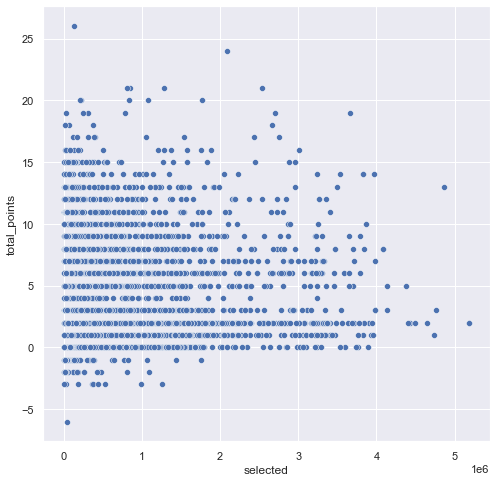

In [50]:
plt.figure(figsize=(8,8))
data = players[players['season'] == 1920][['total_points', 'selected']]
sns.scatterplot(data = data, x = 'selected', y='total_points')

(-500000.0, 500000.0)

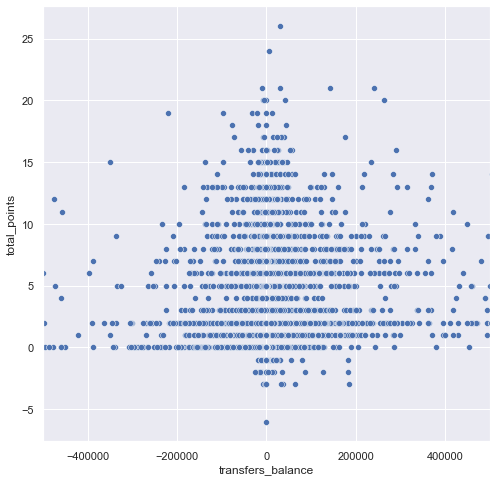

In [51]:
plt.figure(figsize=(8,8))
data = players[players['season'] == 1920][['total_points', 'transfers_balance']]
sns.scatterplot(data = data, x = 'transfers_balance', y='total_points')
plt.xlim(-500000, 500000)

<AxesSubplot:xlabel='selected', ylabel='total_points'>

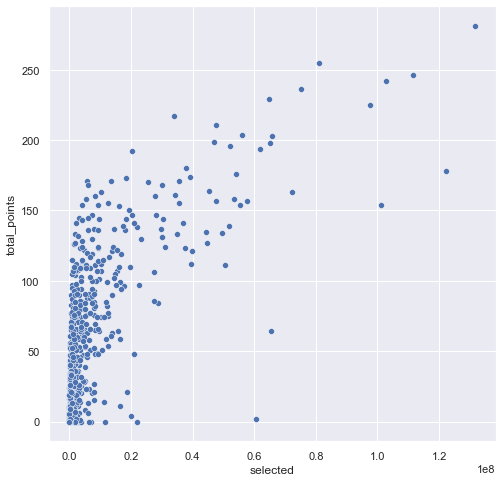

In [52]:
plt.figure(figsize=(8,8))
data = players[players['season'] == 1920].groupby('name')[['total_points', 'selected']].sum().reset_index()
sns.scatterplot(data = data, x = 'selected', y='total_points')

Number of selections starts to matter/make sense at the season level, but we should be careful of putting too much trust in this -- it's possible that a player is highly selected *after* a high-scoring game, such that total selections isn't an effective predictor

In [53]:
data = players.groupby(['name', 'season']).agg({'total_points': ['median', 'sum', 'mean', 'std']}).reset_index()
data.sort_values(('total_points', 'sum'), ascending=False).head(30)

name season total_points                         
                                             median  sum      mean       std
2426              Mohamed Salah   1718          8.0  303  7.973684  5.777341
1911            Kevin De Bruyne   1920          5.5  281  6.386364  5.444075
168              Alexis Sánchez   1617          5.0  264  6.947368  5.321793
2427              Mohamed Salah   1819          6.0  259  6.815789  4.958505
2927                 Sadio Mané   1920          5.0  255  5.795455  4.557537
2428              Mohamed Salah   1920          3.0  246  5.590909  4.966484
3241     Trent Alexander-Arnold   1920          5.5  242  5.500000  4.722534
945                 Eden Hazard   1819          4.0  238  6.263158  5.330606
2747            Raheem Sterling   1920          3.0  236  5.363636  5.460603
2746            Raheem Sterling   1819          5.0  234  6.157895  5.800868
2926                 Sadio Mané   1819          3.0  231  6.078947  4.867885
2745            Raheem Sterling   1718          5.5  229  6.026316  4.582498
2726  Pierre-Emerick Aubameyang   1920          3.0  229  5.204545  4.663463
1500                Jamie Vardy   1920          2.0  225  5.113636  4.871445
367               Bamidele Alli   1617          6.0  225  5.921053  4.206697
943                 Eden Hazard   1617          5.0  224  5.894737  4.397723
1259                 Harry Kane   1617          3.0  224  5.894737  6.475690
2863              Romelu Lukaku   1617          2.0  221  5.815789  5.321325
613           Christian Eriksen   1617          3.0  218  5.736842  4.836149
289             Anthony Martial   1920          2.0  217  4.822222  4.623502
1260                 Harry Kane   1718          3.0  217  5.710526  5.250008
228            Andrew Robertson   1819          6.0  213  5.605263  3.759956
766                  Danny Ings   1920          4.0  211  4.906977  3.753182
1909            Kevin De Bruyne   1718          3.5  209  5.500000  3.930133
3298            Virgil van Dijk   1819          6.0  208  5.473684  4.157291
2725  Pierre-Emerick Aubameyang   1819          4.5  205  5.394737  4.517470
2183            Marcus Rashford   1920          2.0  204  4.533333  4.054179
229            Andrew Robertson   1920          5.0  203  4.613636  3.020980
3017              Sergio Agüero   1819          5.0  201  5.289474  4.996798
2538                  Nick Pope   1920          3.0  199  4.522727  3.467380

Even the best players have many, many games in which they don't earn many points. Aubemeyang, in 2019-2020, for example, earned 208 points for the season with a median of only 2 points!

<AxesSubplot:xlabel="('total_points', 'mean')", ylabel="('total_points', 'std')">

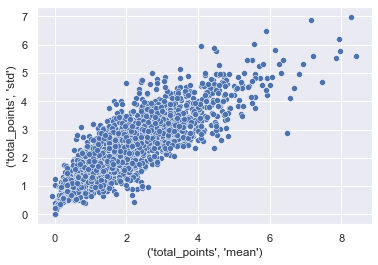

In [54]:
sns.scatterplot(x = data[('total_points', 'mean')], 
                y = data[('total_points', 'std')])

We can see this in the graph above. While I would have thought that the players that earn the most points over the season are the ones who can just produce a solid 5 points, day in and day out, it's actually the players with larger variance in their points that have higher season-long averages

<AxesSubplot:xlabel='date', ylabel='total_points'>

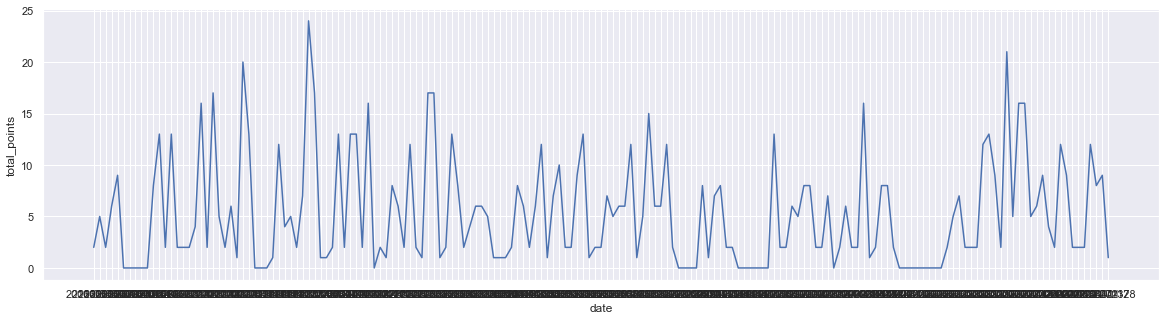

In [55]:
data = players[players.name == 'Harry Kane'][['total_points', 'date']]
plt.figure(figsize=(20,5))
sns.lineplot(x='date', y='total_points', data=data)

In [56]:
data['rolling'] = data.total_points.rolling(4, min_periods=1).sum()

<AxesSubplot:xlabel='date', ylabel='rolling'>

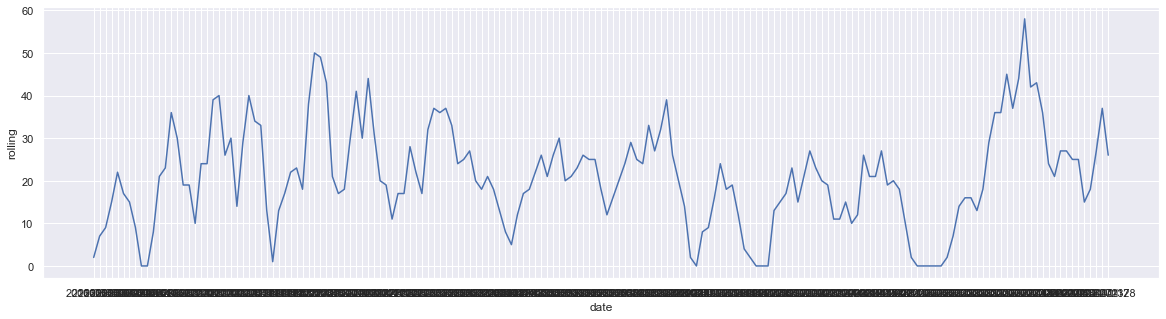

In [57]:
plt.figure(figsize=(20,5))
sns.lineplot(x='date', y='rolling', data=data)

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

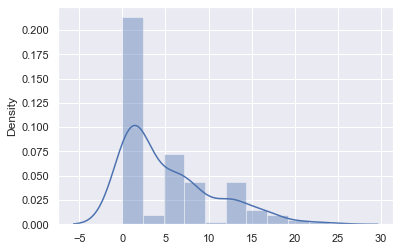

In [58]:
sns.distplot(data['total_points'].values)

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

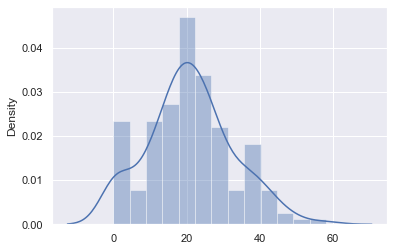

In [59]:
sns.distplot(data['rolling'].values)

looking at this in 4 game spans significantly smoothes the data for Harry Kane, And continues to look much better & less eratice for players as a whole

In [60]:
rolling_points = players.groupby('name')['total_points'].rolling(4, min_periods=2).sum().reset_index()

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_points', ylabel='Density'>

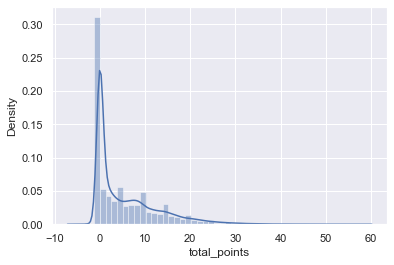

In [61]:
sns.distplot(rolling_points['total_points'])

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_points', ylabel='Density'>

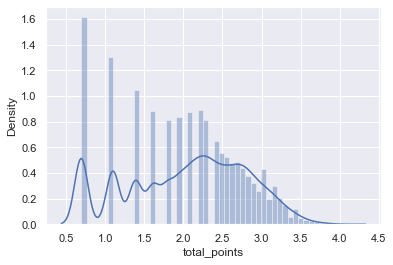

In [62]:
sns.distplot(np.log1p(rolling_points[rolling_points['total_points'] > 0]['total_points']))

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_points', ylabel='Density'>

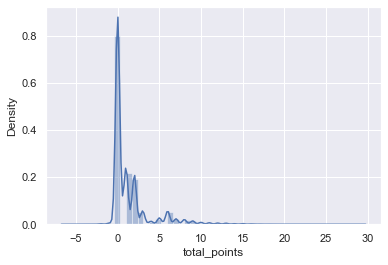

In [63]:
sns.distplot(players['total_points'])

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_points', ylabel='Density'>

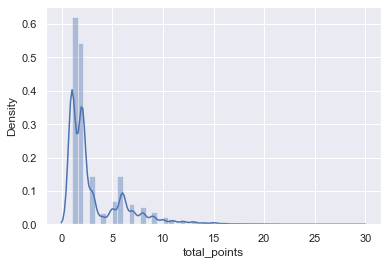

In [64]:
sns.distplot(players[players['total_points'] > 0]['total_points'])

# Feature Engineering

## Create rolling averages to show player performance on a given feature over the past X number of games

In [51]:
players['spi_d'] = players['spi'] - players['spi_opp']
players['proj_score_d'] = players['proj_score'] - players['proj_score_opp']

In [54]:
check_538_df = players[players.was_home == True]

In [57]:
check_538_df = check_538_df.loc[:, ['team_h_score', 'proj_score']] 

<AxesSubplot:xlabel='team_h_score', ylabel='proj_score'>

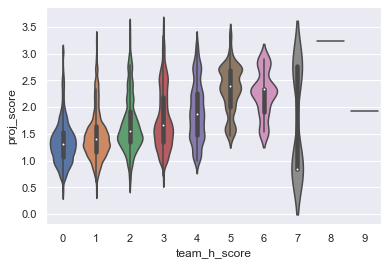

In [59]:
sns.violinplot(x='team_h_score', y='proj_score', data=check_538_df)

the 538 predictions aren't too impressive here -- I'm not sure how useful this will be for us

In [66]:
#I'm going to begin by shifting feature rows, so that we don't inadvertantly use data from a 
# game to try to predict points earned in that same game

rolling_cols = ['total_points', 'bps', 'creativity', 'ict_index', 'influence', 
                'threat', 'minutes', 'transfers_balance']
players = players.sort_values(['name', 'date'])
players = players.join(players.groupby('name')[rolling_cols].shift(), rsuffix = '_shift')

In [67]:
# Now I'll calculate rolling performance, using the shifted data
rolling_cols = ['total_points_shift', 'bps_shift', 'creativity_shift', 
                'ict_index_shift', 'influence_shift', 'threat_shift']
players = players.sort_values(['name', 'date'])

rolling_3 = players.groupby('name')[rolling_cols].rolling(window=3, min_periods=1).mean().reset_index()
rolling_5 = players.groupby('name')[rolling_cols].rolling(window=5, min_periods=1).mean().reset_index()
rolling_7 = players.groupby('name')[rolling_cols].rolling(window=7, min_periods=1).mean().reset_index()
rolling_30 = players.groupby('name')[rolling_cols].rolling(window=30, min_periods=1).mean().reset_index()

In [68]:
rolling_3_5 = rolling_3.merge(rolling_5, on='level_1', suffixes=['_3', '_5'])
rolling_7_30 = rolling_7.merge(rolling_30, on='level_1', suffixes=['_7', '_30'])
rolling_performance = rolling_3_5.merge(rolling_7_30, on='level_1')

In [69]:
players = players.merge(rolling_performance, left_index = True, right_on = 'level_1')

In [70]:
#Now calculate rolling values for columns that are more important in the near term, like player minutes and transfer balance

rolling_cols = ['minutes_shift', 'transfers_balance_shift']
players = players.sort_values(['name', 'date'])

rolling_2 = players.groupby('name')[rolling_cols].rolling(window=2, min_periods=1).mean().reset_index()
rolling_3 = players.groupby('name')[rolling_cols].rolling(window=3, min_periods=1).mean().reset_index()
rolling_5 = players.groupby('name')[rolling_cols].rolling(window=5, min_periods=1).mean().reset_index()

In [71]:
rolling_3_5 = rolling_3.merge(rolling_5, on='level_1', suffixes=['_3', '_5'])
rolling_2 = rolling_2.rename(columns={'minutes_shift': 'minutes_shift_2',
                         'transfers_balance_shift': 'transfers_balance_shift_2'})
rolling_value = rolling_2.merge(rolling_3_5, on='level_1')

In [72]:
players = players.merge(rolling_value, left_index = True, right_on = 'level_1')

In [73]:
list(players)

['level_1',
 'name_x',
 'gw',
 'position',
 'minutes',
 'team',
 'opponent_team',
 'was_home',
 'total_points',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'penalties_missed',
 'penalties_saved',
 'red_cards',
 'saves',
 'selected',
 'team_a_score',
 'team_h_score',
 'threat',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'yellow_cards',
 'kickoff_time',
 'season',
 'value',
 'date',
 'team_opp',
 'spi',
 'spi_opp',
 'proj_score',
 'proj_score_opp',
 'prob_w',
 'prob_l',
 'probtie',
 'importance',
 'importance_opp',
 'spi_d',
 'proj_score_d',
 'total_points_shift',
 'bps_shift',
 'creativity_shift',
 'ict_index_shift',
 'influence_shift',
 'threat_shift',
 'minutes_shift',
 'transfers_balance_shift',
 'name_3_x',
 'level_1_x',
 'total_points_shift_3',
 'bps_shift_3',
 'creativity_shift_3',
 'ict_index_shift_3',
 'influence_shift_3',
 'threat_shift_3',
 'name_5_x',
 'total_points_shift_5',
 'b

In [74]:
players = players.rename(columns={'name_x': 'name'})

In [75]:
players = players.drop(columns=['level_1', 'name_3_x', 'level_1_x', 'name_5_x', 'name_7', 'name_30', 'name_y', 'level_1_y',
                     'name_3_y', 'name_5_y'])

In [76]:
# shifting the data gives us NaN for the first record we have of each player
# for now, we're going to drop NaNs

players = players.dropna()

In [77]:
players.sort_values(['name', 'date'])

,name,gw,position,minutes,team,opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,value,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp,spi_d,proj_score_d,total_points_shift,bps_shift,creativity_shift,ict_index_shift,influence_shift,threat_shift,minutes_shift,transfers_balance_shift,total_points_shift_3,bps_shift_3,creativity_shift_3,ict_index_shift_3,influence_shift_3,threat_shift_3,total_points_shift_5,bps_shift_5,creativity_shift_5,ict_index_shift_5,influence_shift_5,threat_shift_5,total_points_shift_7,bps_shift_7,creativity_shift_7,ict_index_shift_7,influence_shift_7,threat_shift_7,total_points_shift_30,bps_shift_30,creativity_shift_30,ict_index_shift_30,influence_shift_30,threat_shift_30,minutes_shift_2,transfers_balance_shift_2,minutes_shift_3,transfers_balance_shift_3,minutes_shift_5,transfers_balance_shift_5
1,Aaron Connolly,5,4,6,Brighton and Hove Albion,Burnley,True,1,0,0,1,0,0.3,1,0,2.2,1.0,0,0,0,0,14029,1,1,21.0,10589,13500,2911,0,2019-09-14T14:00:00Z,1920,0.0,2019-09-14,Burnley,64.86,69.10,1.35,1.14,0.4130,0.3114,0.2756,44.2,27.6,-4.24,0.21,1.0,1.0,0.1,0.0,0.2,0.0,24.0,0.0,1.0,1.000000,1.000000e-01,0.000000,0.200000,0.000000,1.0,1.00,1.000000e-01,0.000000e+00,2.000000e-01,0.00,1.0,1.00,1.000000e-01,0.000000e+00,0.200000,0.00,1.0,1.000000,0.100000,0.000000,0.200000,0.00,24.0,0.0,24.000000,0.000000,24.000000,0.000000
2,Aaron Connolly,6,4,20,Brighton and Hove Albion,Newcastle United,False,1,0,0,1,0,4.8,0,0,2.5,2.0,0,0,0,0,22804,0,0,18.0,8090,11749,3659,0,2019-09-21T16:30:00Z,1920,0.0,2019-09-21,Newcastle United,65.56,68.53,0.94,1.41,0.2498,0.4730,0.2772,43.9,39.4,-2.97,-0.47,1.0,1.0,0.3,2.2,1.0,21.0,6.0,10589.0,1.0,1.000000,2.000000e-01,1.100000,0.600000,10.500000,1.0,1.00,2.000000e-01,1.100000e+00,6.000000e-01,10.50,1.0,1.00,2.000000e-01,1.100000e+00,0.600000,10.50,1.0,1.000000,0.200000,1.100000,0.600000,10.50,15.0,5294.5,15.000000,5294.500000,15.000000,5294.500000
3,Aaron Connolly,7,4,25,Brighton and Hove Albion,Chelsea,False,1,0,0,2,0,0.6,1,0,0.1,0.2,0,0,0,0,32699,0,2,0.0,8437,13439,5002,0,2019-09-28T14:00:00Z,1920,0.0,2019-09-28,Chelsea,66.70,84.10,0.69,2.14,0.1060,0.7050,0.1889,34.8,60.3,-17.40,-1.45,1.0,1.0,4.8,2.5,2.0,18.0,20.0,8090.0,1.0,1.000000,1.733333e+00,1.566667,1.066667,13.000000,1.0,1.00,1.733333e+00,1.566667e+00,1.066667e+00,13.00,1.0,1.00,1.733333e+00,1.566667e+00,1.066667,13.00,1.0,1.000000,1.733333,1.566667,1.066667,13.00,13.0,9339.5,16.666667,6226.333333,16.666667,6226.333333
4,Aaron Connolly,8,4,79,Brighton and Hove Albion,Tottenham Hotspur,True,13,0,3,53,1,23.8,0,2,20.1,70.2,0,0,0,0,35026,0,3,107.0,2156,5952,3796,0,2019-10-05T11:30:00Z,1920,0.0,2019-10-05,Tottenham Hotspur,65.79,82.63,1.07,1.74,0.2294,0.5279,0.2426,37.9,61.3,-16.84,-0.67,1.0,2.0,0.6,0.1,0.2,0.0,25.0,8437.0,1.0,1.333333,1.900000e+00,1.600000,1.066667,13.000000,1.0,1.25,1.450000e+00,1.200000e+00,8.500000e-01,9.75,1.0,1.25,1.450000e+00,1.200000e+00,0.850000,9.75,1.0,1.250000,1.450000,1.200000,0.850000,9.75,22.5,8263.5,17.000000,9038.666667,18.750000,6779.000000
5,Aaron Connolly,9,4,45,Brighton and Hove Albion,Aston Villa,False,1,0,0,3,0,10.6,1,0,3.6,4.4,0,0,0,0,110944,1,2,21.0,70802,81069,10267,0,2019-10-19T14:00:00Z,1920,0.0,2019-10-19,Aston Villa,68.56,65.69,1.12,1.43,0.2921,0.4381,0.2699,34.4,43.5,2.87,-0.31,13.0,53.0,23.8,20.1,70.2,107.0,79.0,2156.0,5.0,18.666667,9.733333e+00,7.566667,24.133333,41.666667,3.4,11.60,5.920000e+00,4.980000e+00,1.472000e+01,29.20,3.4,11.60,5.920000e+00,4.980000e+00,14.720000,29.20,3.4,11.600000,5.920000,4.980000,14.720000,29.20,52.0,5296.5,41.333333,6227.666667,30.800000,5854.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

# Normalize data

In [78]:
players.position = players.position.replace({'GK': 1,
                                            'DEF': 2,
                                            'MID': 3,
                                            'FWD': 4})

In [79]:
# treat negative points earned as zero
players.loc[players['total_points'] < 0, 'total_points'] = 0

In [80]:
players.describe()

,gw,position,minutes,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,season,value,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp,spi_d,proj_score_d,total_points_shift,bps_shift,creativity_shift,ict_index_shift,influence_shift,threat_shift,minutes_shift,transfers_balance_shift,total_points_shift_3,bps_shift_3,creativity_shift_3,ict_index_shift_3,influence_shift_3,threat_shift_3,total_points_shift_5,bps_shift_5,creativity_shift_5,ict_index_shift_5,influence_shift_5,threat_shift_5,total_points_shift_7,bps_shift_7,creativity_shift_7,ict_index_shift_7,influence_shift_7,threat_shift_7,total_points_shift_30,bps_shift_30,creativity_shift_30,ict_index_shift_30,influence_shift_30,threat_shift_30,minutes_shift_2,transfers_balance_shift_2,minutes_shift_3,transfers_balance_shift_3,minutes_shift_5,transfers_balance_shift_5
count,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,1.006920e+05,100692.000000,100692.000000,100692.000000,1.006920e+05,1.006920e+05,1.006920e+05,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,1.006920e+05,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,1.006920e+05,1.006920e+05,1.006920e+05,100692.000000,100692.000000,100692.000000,1.006920e+05,1.006920e+05,1.006920e+05,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,100692.000000,1.006920e+05,100692.000000,1.006920e+05,100692.000000,100692.000000
mean,19.382116,2.589530,33.223265,1.389435,0.040847,0.107953,6.234696,0.108221,4.959993,0.509008,0.044830,1.791205,7.459159,0.000993,0.000755,0.001937,0.098002,1.507872e+05,1.214843,1.533101,5.505452,5.173132e+02,1.001253e+04,9.494634e+03,0.055297,1792.415932,1.875144,69.477743,69.683115,1.398401,1.412109,0.379834,0.384777,0.235391,34.763017,34.905239,-0.205372,-0.013708,1.386337,6.250626,4.971749,1.795456,7.476185,5.519624,33.318436,5.242526e+02,1.390822,6.272228,4.986149,1.801181,7.502505,5.536521,1.395359,6.295056,5.005831e+00,1.808134e+00,7.531101e+00,5.558105,1.400602,6.320986,5.027844e+00,1.815702e+00,7.562227e+00,5.580974,1.451484,6.565621,5.253510,1.891013,7.848541,5.824791,33.370933,5.243984e+02,33.425832,5.115554e+02,33.541092,508.065156
std,10.883822,0.859219,40.829465,2.521395,0.215290,0.490371,9.929045,0.310661,10.999004,0.978292,0.232044,3.105518,13.077721,0.031498,0.028177,0.043964,0.640030,3.551499e+05,1.216669,1.301874,13.771089,4.467754e+04,3.825196e+04,3.348671e+04,0.228561,129.207511,9.925192,11.965351,12.053970,0.553214,0.559248,0.205443,0.206507,0.051916,25.863098,25.908968,16.413080,1.052699,2.527335,9.931069,11.003750,3.105259,13.077852,13.768772,40.838705,4.417906e+04,1.911294,7.952607,8.772858,2.527634,10.196616,10.797406,1.743032,7.391842,8.198289e+00,2.369663e+00,9.402943e+00,10.033736,1.657826,7.096686,7.908845e+00,2.287052e+00,8.994888e+00,9.655897,1.429389,6.232435,7.233563,2.068665,7.852898,8.795689,38.001671,3.592896e+04,36.665718,3.136812e+04,35.092549,25860.348386
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-1.347561e+06,0.000000e+00,0.000000e+00,0.000000,1617.000000,0.000000,42.970000,42.970000,0.200000,0.200000,0.008000,0.008000,0.053100,0.000000,0.000000,-44

The total points data is incredibly skewed left, because 50% of rows represent players who played 0 minutes

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

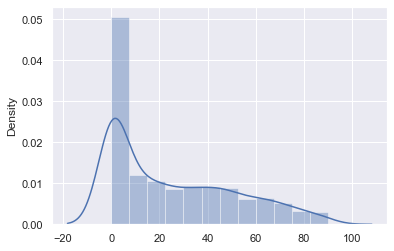

In [81]:
# Distribution of mean minutes played, aggreagated by player
# lots of players where their *mean* over all games is less than 25 minutes
sns.distplot(players.groupby('name')['minutes'].mean().values)

## How do we handle players with low minutes?

The open question here is to what degree this program should tacitly predict the number of minutes a player will play, or whether or not it should assume everyone plays 90 minutes, and it is the human manager who is responsible for adjusting those numbers.

My thought is that this program should be reasonably equipped to see that players that are consistenly playing low minutes are not good picks, but that it will need to be up to the human to fine tune

In [82]:
#feature to show the total number of minutes a player has played in the past 3 games
players['total_mins_past_3'] = players['minutes_shift'] + players['minutes_shift_2'] + players['minutes_shift_3']

In [83]:
#it's pretty clear that, in general, as a player pays more, they earn more points
players.groupby(pd.cut(players.total_mins_past_3, 10))['total_points'].mean()

total_mins_past_3
(-0.27, 27.0]     0.239579
(27.0, 54.0]      1.092940
(54.0, 81.0]      1.393652
(81.0, 108.0]     1.661184
(108.0, 135.0]    2.029428
(135.0, 162.0]    2.072198
(162.0, 189.0]    2.239199
(189.0, 216.0]    2.464344
(216.0, 243.0]    2.788034
(243.0, 270.0]    3.135389
Name: total_points, dtype: float64

In [84]:
#there's also a large number of players that simply aren't playing -- removing players who have played 
# less than 30 minutes in the past three games will remove 47k players!
players.groupby(pd.cut(players.total_mins_past_3, 10))['total_points'].count()

total_mins_past_3
(-0.27, 27.0]     48698
(27.0, 54.0]       5014
(54.0, 81.0]       3686
(81.0, 108.0]      4256
(108.0, 135.0]     1767
(135.0, 162.0]     1856
(162.0, 189.0]     4097
(189.0, 216.0]     3702
(216.0, 243.0]     5081
(243.0, 270.0]    22535
Name: total_points, dtype: int64

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_points', ylabel='Density'>

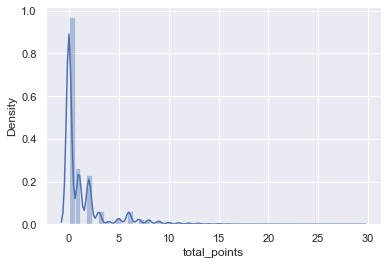

In [85]:
sns.distplot(players.total_points)

In [86]:
len(players)

100692

In [87]:
players = players[players['total_mins_past_3'] > 30]

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_mins_past_3', ylabel='Density'>

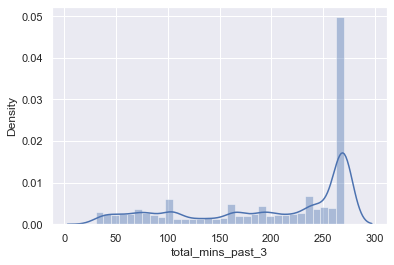

In [88]:
sns.distplot(players.total_mins_past_3)

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_points', ylabel='Density'>

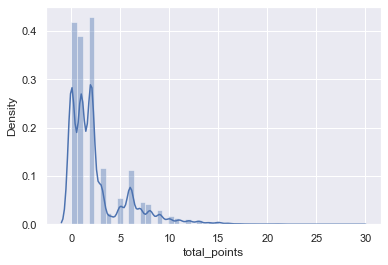

In [89]:
sns.distplot(players.total_points)

## Visualizing Feature Correlation with Total Points

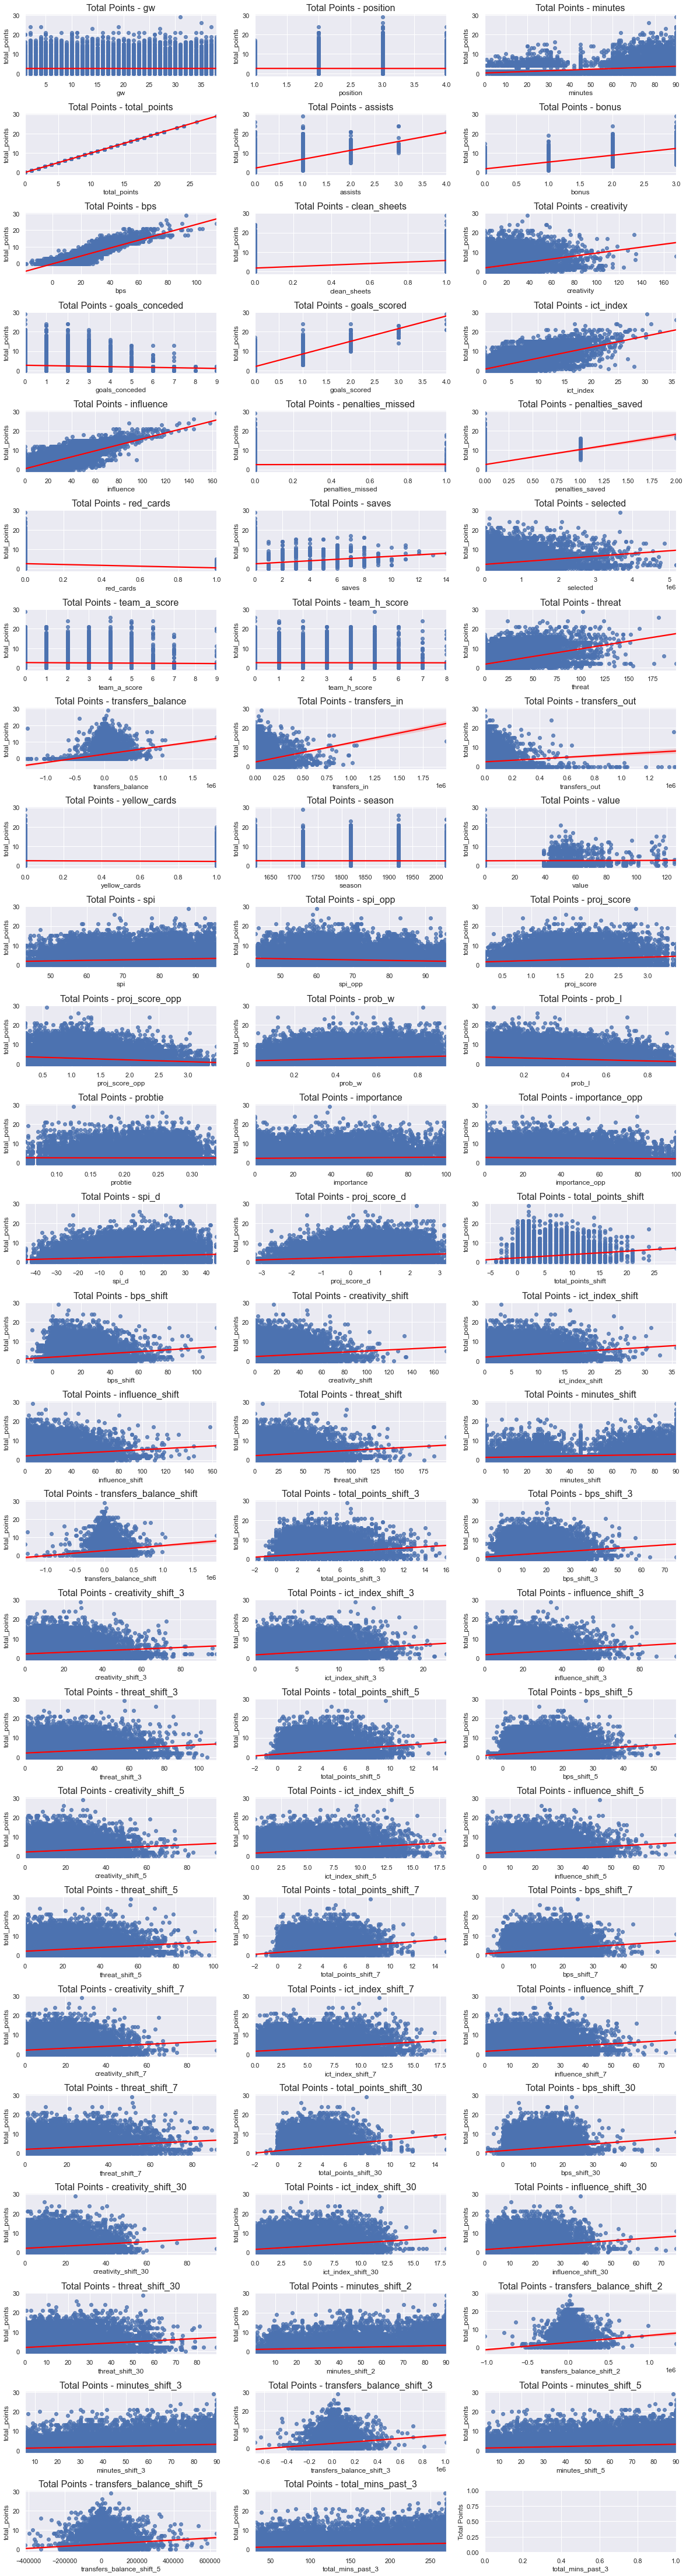

In [90]:
#Heads-up: this prints a lot of graphs, and can take a minute or two to run

players_num = players.select_dtypes(include=['int64','float64'])
fig , axs= plt.subplots(int(np.ceil(len(list(players_num))/3)), 3, figsize=(20,80))
#adjust horizontal space between plots 
fig.subplots_adjust(hspace=0.6)
for i,ax in zip(players_num.columns,axs.flatten()):
    sns.regplot(x = i, y = 'total_points',data = players_num, ax = ax, color = 'b', line_kws={'color': 'red'})
    plt.xlabel(i,fontsize=12)
    plt.ylabel('Total Points',fontsize=12)
    #ax.set_yticks(np.arange(0,900001,100000))
    ax.set_title('Total Points'+' - '+str(i),size=16)

Most of the 538 features have no correlation with total points! Consider dropping spi, spi_opp, proj_score, proj_score_opp

In [91]:
print("Skewness: %f" % players['total_points'].skew())
print("Kurtosis: %f" % players['total_points'].kurt())

Skewness: 1.965050
Kurtosis: 4.568064


# A Bit More Feature Engineering: Team-Level Points Data

In [92]:
#instead of using spi to evaluate matches, we can use team-level fpl points data
team_level = players.groupby(['team', 'date', 'position'])['total_points'].sum().reset_index()

In [93]:
team_level = team_level.pivot_table(index=['team', 'date'], columns = 'position')['total_points'].reset_index()

In [94]:
team_level.head()

position,team,date,1,2,3,4
0,Arsenal,2016-08-20,6.0,23.0,17.0,NaN
1,Arsenal,2016-08-27,4.0,8.0,43.0,NaN
2,Arsenal,2016-09-10,1.0,13.0,18.0,NaN
3,Arsenal,2016-09-17,1.0,8.0,35.0,1.0
4,Arsenal,2016-09-24,6.0,29.0,40.0,0.0


This seems strange (and may indicate a shortcoming of this technique), but the NaN's above are correct: Arsenal didn't play any players described as a FWD by FPL those weeks. Or: they did, but I removed them because they didn't meet the minutes threshold.

In [95]:
players[(players.team == 'Arsenal') & (players.date == '2016-08-20') & (players.position == 4)]

,name,gw,position,minutes,team,opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,value,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp,spi_d,proj_score_d,total_points_shift,bps_shift,creativity_shift,ict_index_shift,influence_shift,threat_shift,minutes_shift,transfers_balance_shift,total_points_shift_3,bps_shift_3,creativity_shift_3,ict_index_shift_3,influence_shift_3,threat_shift_3,total_points_shift_5,bps_shift_5,creativity_shift_5,ict_index_shift_5,influence_shift_5,threat_shift_5,total_points_shift_7,bps_shift_7,creativity_shift_7,ict_index_shift_7,influence_shift_7,threat_shift_7,total_points_shift_30,bps_shift_30,creativity_shift_30,ict_index_shift_30,influence_shift_30,threat_shift_30,minutes_shift_2,transfers_balance_shift_2,minutes_shift_3,transfers_balance_shift_3,minutes_shift_5,transfers_balance_shift_5,total_mins_past_3


In [96]:
team_level = team_level.fillna(0)

In [97]:
team_level = team_level.rename(columns={1: 'gk_points', 2: 'def_points', 3: 'mid_points', 4: 'fwd_points'})

In [98]:
rolling_team_3 = (team_level.groupby('team').rolling(window=3, min_periods=1, on='date').
    mean().reset_index().drop('level_1', axis=1))

In [99]:
rolling_team_5 = (team_level.groupby('team').rolling(window=5, min_periods=1, on='date').
    mean().reset_index().drop('level_1', axis=1))

In [100]:
rolling_team_7 = (team_level.groupby('team').rolling(window=7, min_periods=1, on='date').
    mean().reset_index().drop('level_1', axis=1))

In [101]:
rolling_team_12 = (team_level.groupby('team').rolling(window=12, min_periods=1, on='date').
    mean().reset_index().drop('level_1', axis=1))

In [102]:
rolling_team_35 = rolling_team_3.merge(rolling_team_5, on=['team', 'date'], suffixes = ['_3', '_5'])
rolling_team_712 = rolling_team_7.merge(rolling_team_12, on=['team', 'date'], suffixes = ['_7', '_12'])

In [103]:
rolling_team = rolling_team_35.merge(rolling_team_712, on=['team', 'date'])

In [104]:
players = players.merge(rolling_team, on = ['team', 'date'])

In [105]:
#add in opponent past performance
players = players.merge(rolling_team, left_on = ['opponent_team', 'date'], right_on = ['team', 'date'],
             suffixes = ['', '_opp'])

In [106]:
# for each feature, look at how the teams stack up against one another: eg, how many more points have Arsenal's
# midfielders earned, on average, in the past 3 gameweeks than their opponents' midfielders?
for col in ['gk_points', 'def_points', 'mid_points', 'fwd_points']:
    for window in ['_3', '_5', '_7', '_12']:
        players[col + window + '_adv'] = players[col + window] - players[col + window + '_opp']

In [109]:
players

,name,gw,position,minutes,team,opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,value,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp,spi_d,proj_score_d,total_points_shift,bps_shift,creativity_shift,ict_index_shift,influence_shift,threat_shift,minutes_shift,transfers_balance_shift,total_points_shift_3,bps_shift_3,creativity_shift_3,ict_index_shift_3,influence_shift_3,threat_shift_3,total_points_shift_5,bps_shift_5,creativity_shift_5,ict_index_shift_5,influence_shift_5,threat_shift_5,total_points_shift_7,bps_shift_7,creativity_shift_7,ict_index_shift_7,influence_shift_7,threat_shift_7,total_points_shift_30,bps_shift_30,creativity_shift_30,ict_index_shift_30,influence_shift_30,threat_shift_30,minutes_shift_2,transfers_balance_shift_2,minutes_shift_3,transfers_balance_shift_3,minutes_shift_5,transfers_balance_shift_5,total_mins_past_3,gk_points_3,def_points_3,mid_points_3,fwd_points_3,gk_points_5,def_points_5,mid_points_5,fwd_points_5,gk_points_7,def_points_7,mid_points_7,fwd_points_7,gk_points_12,def_points_12,mid_points_12,fwd_points_12,team_opp,gk_points_3_opp,def_points_3_opp,mid_points_3_opp,fwd_points_3_opp,gk_points_5_opp,def_points_5_opp,mid_points_5_opp,fwd_points_5_opp,gk_points_7_opp,def_points_7_opp,mid_points_7_opp,fwd_points_7_opp,gk_points_12_opp,def_points_12_opp,mid_points_12_opp,fwd_points_12_opp,gk_points_3_adv,gk_points_5_adv,gk_points_7_adv,gk_points_12_adv,def_points_3_adv,def_points_5_adv,def_points_7_adv,def_points_12_adv,mid_points_3_adv,mid_points_5_adv,mid_points_7_adv,mid_points_12_adv,fwd_points_3_adv,fwd_points_5_adv,fwd_points_7_adv,fwd_points_12_adv
0,Aaron Connolly,5,4,6,Brighton and Hove Albion,Burnley,True,1,0,0,1,0,0.3,1,0,2.2,1.0,0,0,0,0,14029,1,1,21.0,10589,13500,2911,0,2019-09-14T14:00:00Z,1920,0.0,2019-09-14,Burnley,64.86,69.10,1.35,1.14,0.4130,0.3114,0.2756,44.2,27.6,-4.24,0.21,1.0,1.0,0.1,0.0,0.2,0.0,24.0,0.0,1.000000,1.000000,0.100000,0.000000,0.200000,0.000000,1.0,1.00,0.10,0.000000,0.20,0.000000,1.000000,1.000000,0.100000,0.000000,0.200000,0.000000,1.000000,1.000000,0.100000,0.000000,0.200000,0.000000,24.0,0.0,24.000000,0.000000,24.000000,0.0,72.000000,1.000000,3.666667,11.000000,6.0,2.8,7.60,11.0,6.4,2.714286,6.428571,11.571429,7.0,2.833333,7.00,11.0,5.166667,Burnley,2.333333,6.333333,8.666667,6.000000,2.0,11.0,11.0,8.4,1.857143,8.428571,10.285714,7.714286,2.750000,10.916667,12.333333,8.916667,-1.333333,0.8,0.857143,0.083333,-2.666667,-3.40,-2.000000,-3.916667,2.333333,0.0,1.285714,-1.333333,0.000000,-2.0,-0.714286,-3.750000
1,Adam Webster,5,2,90,Brighton and Hove Albion,Burnley,True,2,0,0,12,0,2.3,1,0,1.4,12.0,0,0,0,0,5887,1,1,0.0,-47,414,461,0,2019-09-14T14:00:00Z,1920,0.0,2019-09-14,Burnley,64.86,69.10,1.35,1.14,0.4130,0.3114,0.2756,44.2,27.6,-4.24,0.21,0.0,15.0,0.8,2.1,18.4,2.0,90.0,-542.0,0.000000,5.000000,0.266667,0.700000,6.133333,0.666667,0.0,3.75,0.20,0.525000,4.60,0.500000,0.000000,3.750000,0.200000,0.525000,4.600000,0.500000,0.000000,3.750000,0.200000,0.525000,4.600000,0.500000,45.0,-621.5,30.000000,-612.666667,22.500000,-459.5,165.000000,1.000000,3.666667,11.000000,6.0,2.8,7.60,11.0,6.4,2.714286,6.428571,11.571429,7.0,2.833333,7.00,11.0,5.166667,Burnley,2.333333,6.333333,8.666667,6.000000,2.0,11.0,11.0,8.4,1.857143,8.428571,10.285714,7.714286,2.750000,10.916667,12.333333,8.916667,-1.333333,0.8,0.857143,0.083333,-2.666667,-3.40,-2.000000,-3.916667,2.333333,0.0,1.285714,-1.333333,0.000000,-2.0,-0.714286,-3.750000
2,Bernardo Fernandes da Silva Junior,5,2,0,Brighton and Hove Albion,Burnley,True,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,10335,1,1,0.0,-13,685,698,0,2019-09-14T14:00:00Z,1920,0.0,2019-09-14,Burnley,64.86,69.10,1.35,1.14,0.4130,0.3114,0.2756,44.2,27.6,-4.24,0.21,1.0,11.0,15.8,2.9,

In [110]:
#define feature_cols
feature_cols = ['position',
'total_points_shift',
 'bps_shift',
 'creativity_shift',
 'ict_index_shift',
 'influence_shift',
 'threat_shift',
 'minutes_shift',
 'transfers_balance_shift',
 'total_points_shift_3',
 'bps_shift_3',
 'creativity_shift_3',
 'ict_index_shift_3',
 'influence_shift_3',
 'threat_shift_3',
 'total_points_shift_5',
 'bps_shift_5',
 'creativity_shift_5',
 'ict_index_shift_5',
 'influence_shift_5',
 'threat_shift_5',
 'total_points_shift_7',
 'bps_shift_7',
 'creativity_shift_7',
 'ict_index_shift_7',
 'influence_shift_7',
 'threat_shift_7',
 'total_points_shift_30',
 'bps_shift_30',
 'creativity_shift_30',
 'ict_index_shift_30',
 'influence_shift_30',
 'threat_shift_30',
 'minutes_shift_2',
 'transfers_balance_shift_2',
 'minutes_shift_3',
 'transfers_balance_shift_3',
 'minutes_shift_5',
 'transfers_balance_shift_5',
 'gk_points_3',
 'def_points_3',
 'mid_points_3',
 'fwd_points_3',
 'gk_points_5',
 'def_points_5',
 'mid_points_5',
 'fwd_points_5',
 'gk_points_7',
 'def_points_7',
 'mid_points_7',
 'fwd_points_7',
 'gk_points_12',
 'def_points_12',
 'mid_points_12',
 'fwd_points_12',
 'gk_points_3_opp',
 'def_points_3_opp',
 'mid_points_3_opp',
 'fwd_points_3_opp',
 'gk_points_5_opp',
 'def_points_5_opp',
 'mid_points_5_opp',
 'fwd_points_5_opp',
 'gk_points_7_opp',
 'def_points_7_opp',
 'mid_points_7_opp',
 'fwd_points_7_opp',
 'gk_points_12_opp',
 'def_points_12_opp',
 'mid_points_12_opp',
 'fwd_points_12_opp',
 'gk_points_3_adv',
 'gk_points_5_adv',
 'gk_points_7_adv',
 'gk_points_12_adv',
 'def_points_3_adv',
 'def_points_5_adv',
 'def_points_7_adv',
 'def_points_12_adv',
 'mid_points_3_adv',
 'mid_points_5_adv',
 'mid_points_7_adv',
 'mid_points_12_adv',
 'fwd_points_3_adv',
 'fwd_points_5_adv',
 'fwd_points_7_adv',
 'fwd_points_12_adv']

<AxesSubplot:>

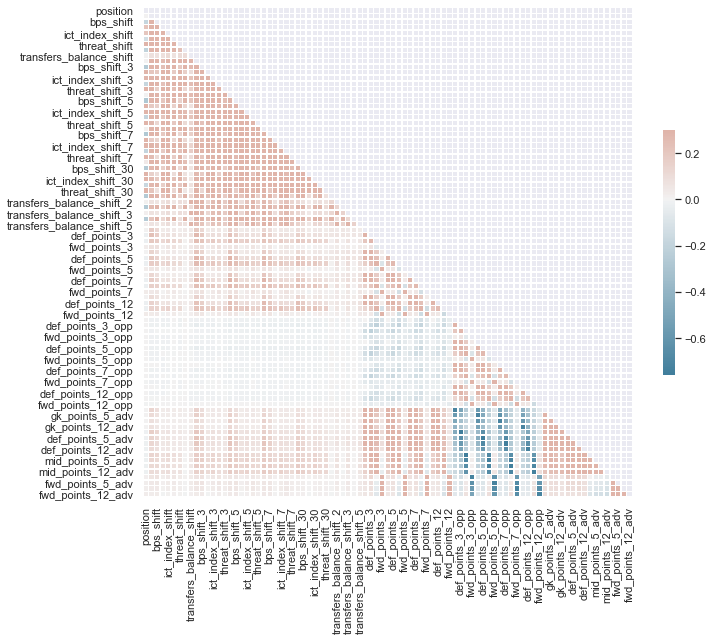

In [111]:
#taken from seaborn gallery

# Compute the correlation matrix
corr = players[feature_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Begin ML Work

In [113]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import SGDClassifier

## Preprocessing


In [114]:
#defined as function so it can easily be repeated for new data
def process(players, features, labels):

    # Encode Position Columns using OHE
    features = features.reset_index(drop=True)
    cat_cols = ['position']
    ohe = OneHotEncoder(sparse=False)
    encoded_columns = ohe.fit_transform(features[cat_cols])
    ohe_positions = pd.DataFrame(encoded_columns)
    features = pd.concat([features, ohe_positions], axis=1)
    features = features.drop(columns='position')
    
    #scale data
    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)
    y = scaler.fit_transform(labels.values.reshape(-1,1))
    return X, y, scaler, features, labels

In [115]:
X, y, scaler, features, labels = process(players, players[feature_cols], players['total_points'])

## Check Distribution of Features and Labels after prepocessing

Loooking to make sure nothing is insanely skewed

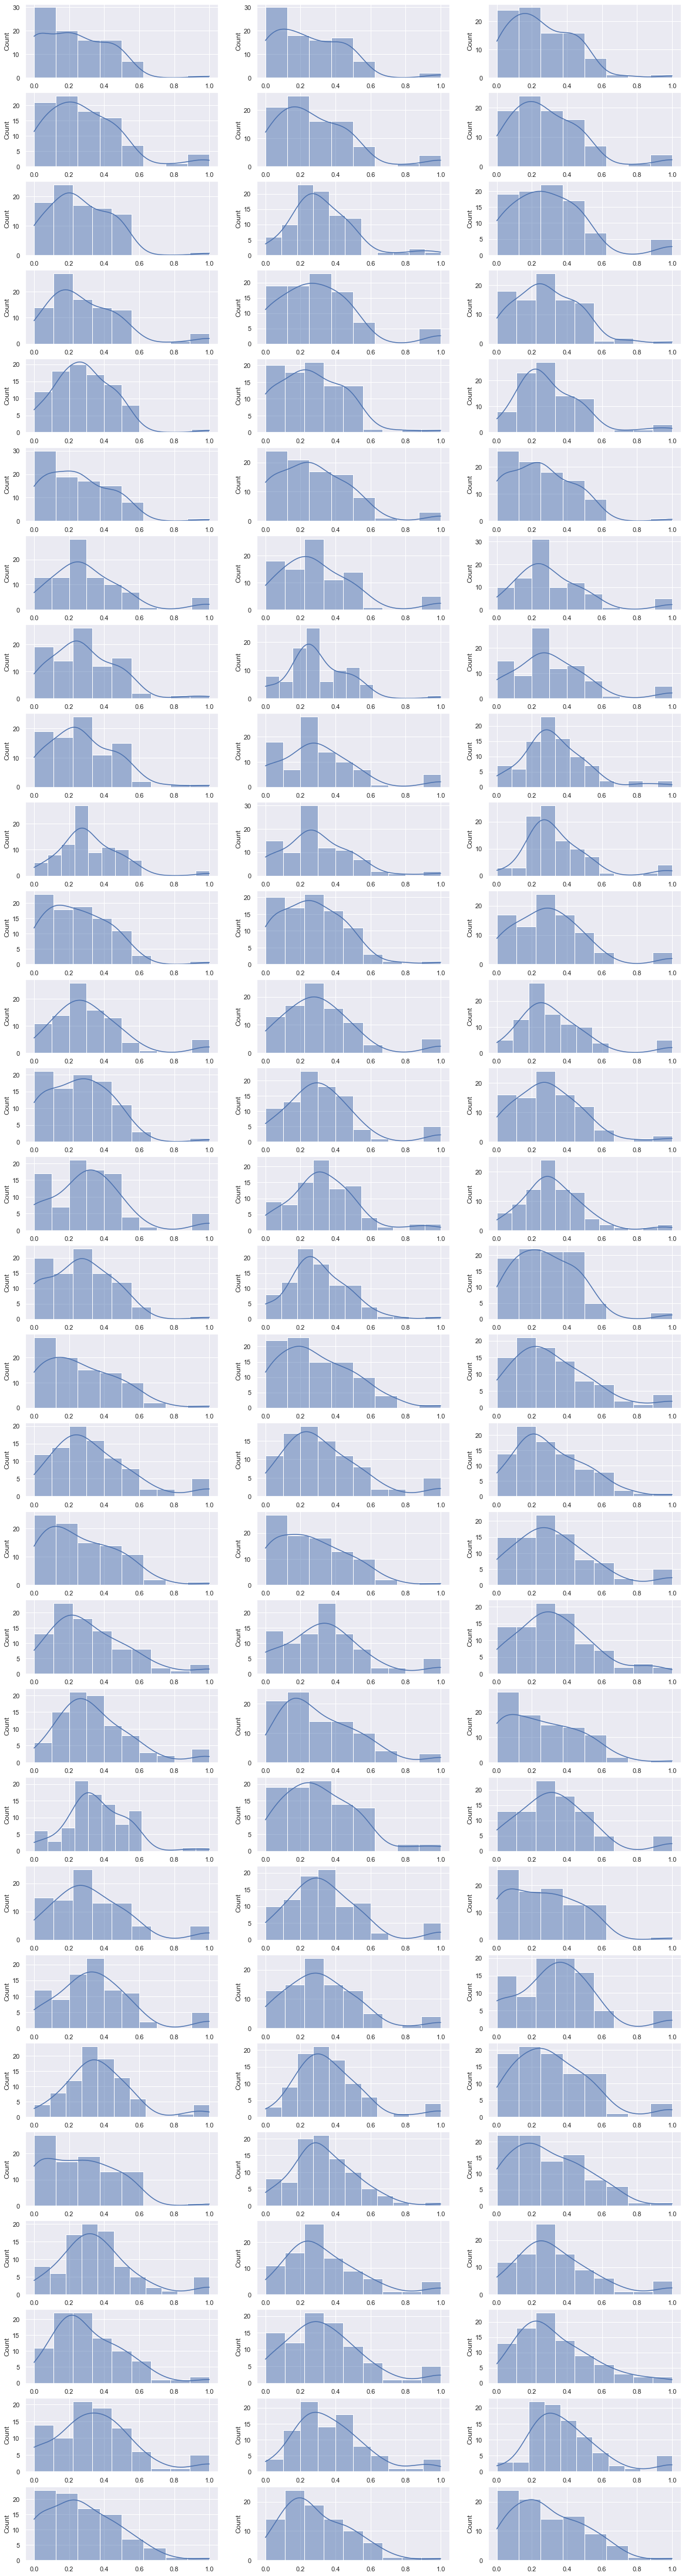

In [116]:
fig, axs = plt.subplots(int(np.ceil(len(feature_cols) / 3)), 3 , figsize=(20,80))
for feature_ax, ax in zip(np.arange(0,X.shape[1], 1), axs.flatten()):
    sns.histplot(X[feature_ax], kde=True, ax=ax)

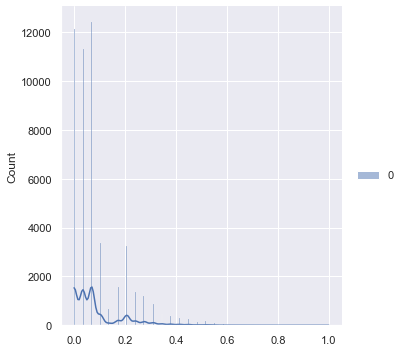

In [117]:
#check that labels are reasonably distributed after transformation
sns.displot(y, kde = True)

Text(0.5, 1.0, 'Probplot y')

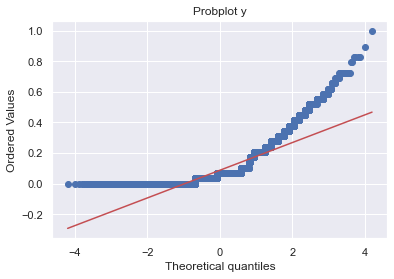

In [118]:
#this is still in pretty rough shape, and likely to continue to give 
# difficulty because of the much higher probability that a player earns close to zero points

fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(y.ravel(), plot=ax)
ax.set_title("Probplot y")

In [119]:
#append player names and dates to the y values, for analysis later (so that they're split with the test-train-split)

y = np.append(y, players.name.to_numpy().reshape(-1,1), axis=1)
y = np.append(y, players.date.to_numpy().reshape(-1,1), axis=1)

# Train Models

## Decision Tree Regressor

tl;dr: the DTR was not anymorer effective than a simple estimate based off a players past 5 games. I'll leave this section for posterity, but this model is not the one

In [122]:
X_train, X_test, y_train_metadata, y_test_metadata = train_test_split(X, y, test_size=0.20,
                                                    random_state=0,
                                                    shuffle=True)

In [123]:
#for simplicity, remove the names and dates and store target values by themselves
y_train = y_train_metadata[:,0]
y_test = y_test_metadata[:,0]

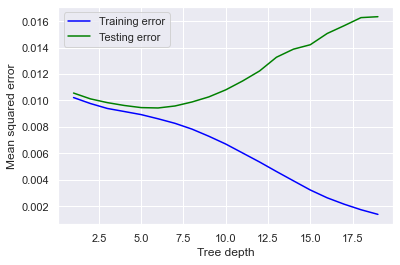

In [124]:
training_error = []
testing_error = []

max_depths = range(1, 20)

for depth in max_depths:
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train, y_train)
    training_error.append(mean_squared_error(model.predict(X_train), y_train))
    testing_error.append(mean_squared_error(model.predict(X_test), y_test))

plt.plot(max_depths, training_error, color='blue', label='Training error')
plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('Tree depth')
plt.ylabel('Mean squared error')
plt.legend()

After a depth of 5-7, the model begins to overfit

In [175]:
dtr = DecisionTreeRegressor(max_depth = 6)

In [176]:
rmse = np.sqrt(mean_squared_error(dtr.fit(X_train, y_train).predict(X_test), y_test))
scaler.inverse_transform(rmse.reshape(-1,1))
#Root Mean Squared Error On Testing Data, inverse transformed so it's intelligible: ~.2.816

array([[2.81591707]])

In [125]:
len(X_train)

39984

In [177]:
float(scaler.inverse_transform(rmse.reshape(-1,1)))

2.8159170666219926

In [240]:
#Assess if model is improving more data
dtr = DecisionTreeRegressor(max_depth = 6)
m = len(X_train)
index = np.arange(0, m)
permu = np.random.permutation(m)
num_samples = 20
rmse_train_list = []
rmse_test_list = []

for sample in np.arange(1,num_samples):
    num_rows = round((m/num_samples)*sample)
    to_keep = permu[:num_rows]
    X_train_reduced = X_train[(to_keep), :]
    y_train_reduced = y_train[to_keep]
    model = dtr.fit(X_train_reduced, y_train_reduced)
    rmse_train = np.sqrt(mean_squared_error(model.predict(X_train_reduced), y_train_reduced))
    rmse_test = np.sqrt(mean_squared_error(model.predict(X_test), y_test))
    rmse_train_list.append(float(scaler.inverse_transform(rmse_train.reshape(-1,1))))
    rmse_test_list.append(float(scaler.inverse_transform(rmse_test.reshape(-1,1))))


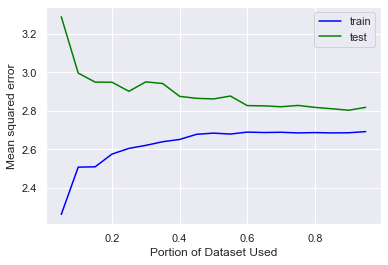

In [241]:
plt.plot(np.arange(1, num_samples)/num_samples, rmse_train_list, color = 'blue', label = 'train')
plt.plot(np.arange(1, num_samples)/num_samples, rmse_test_list, color = 'green', label = 'test')
plt.xlabel('Portion of Dataset Used')
plt.ylabel('Mean squared error')
plt.legend()

There's reason to belive that the above model won't increase in accuracy with additional data. I should try a more complex model.

## Evaluate Model on Test Data

Particularly important to me here is how well it does predicting the points earned by better players. It's easy to return a low mse predicting that poor players will earn 1 point every game

<ipython-input-340-b63d9c3d7250>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


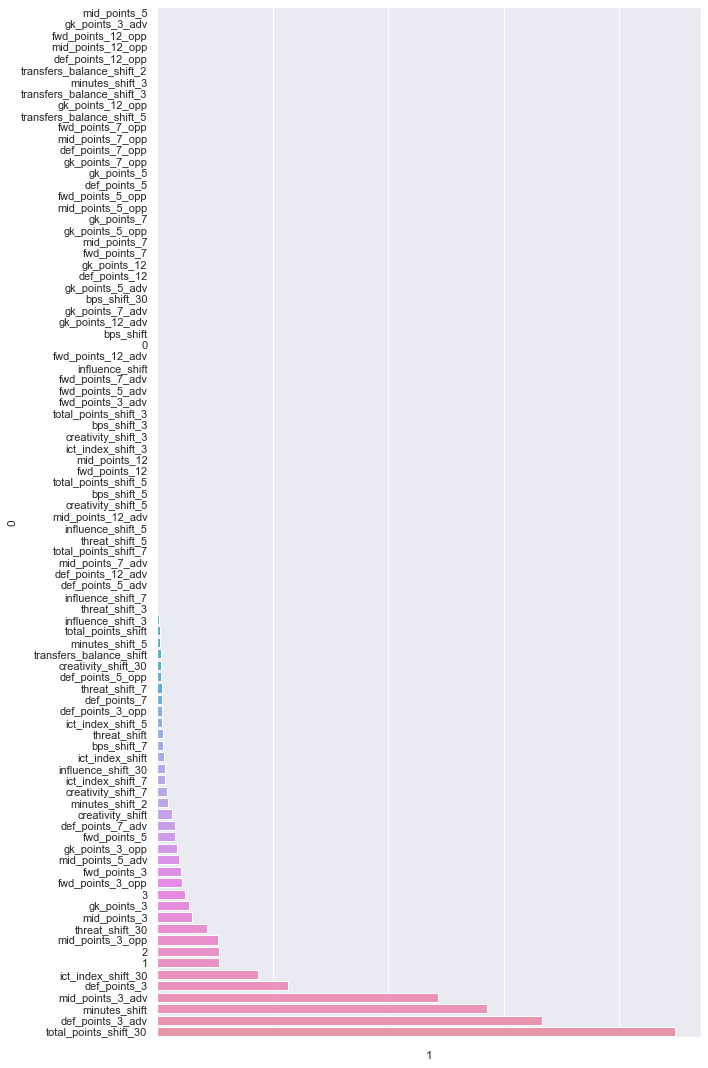

In [340]:
## Look at feature importance in CLF
data = pd.DataFrame(zip(list(features), clf.feature_importances_))
data = data.sort_values(1)
plt.figure(figsize=(10,15))
ax = sns.barplot(x=1, y=0, data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [342]:
test_predictions = scaler.inverse_transform(clf.predict(X_test).reshape(-1,1))
test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

In [428]:
test_df = pd.DataFrame(zip(test_actual, test_predictions), columns = ['actual', 'prediction'], dtype='float')

In [429]:
test_df['residuals'] = test_df['prediction'] - test_df['actual']

<AxesSubplot:xlabel='residuals', ylabel='Count'>

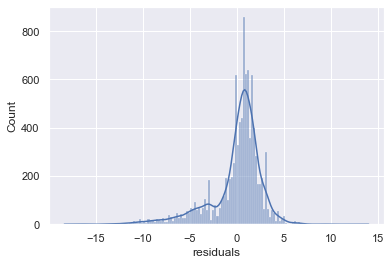

In [430]:
sns.histplot(test_df['residuals'], kde=True)

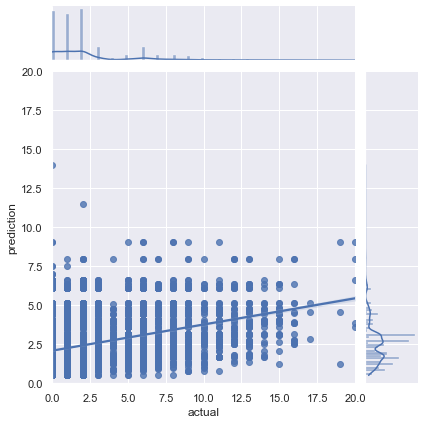

In [431]:
sns.jointplot(x = 'actual', y='prediction', data=test_df, kind='reg', xlim = [0,20], ylim = [0,20])

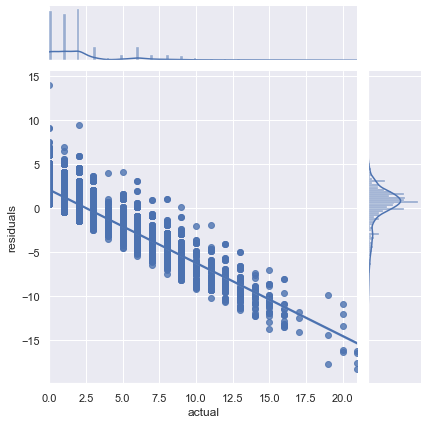

In [432]:
sns.jointplot(x = 'actual', y='residuals', data=test_df, kind='reg')

As expected, the model is much better at predicting players who had poor performances than players who had great performances. I'm curious how this looks when aggregated over multiple games -- though this model isn't good at predicting when Harry Kane will score 20 points in a game, is it pretty good at seeing that he'll do very well over five games?

In [433]:
test_df['name'] = y_test_metadata[:,1]

In [434]:
test_df['date']= y_test_metadata[:,2]

In [371]:
grouped_predictions = test_df.groupby('name').agg({'actual': ['sum', 'count'], 'prediction': 'sum',
                         'residuals': 'sum'}).reset_index()

In [379]:
grouped_predictions.columns = grouped_predictions.columns.map('_'.join)

In [ ]:
grouped_predictions['avg_residual'] = grouped_predictions['residuals_sum']/grouped_predictions['actual_count']

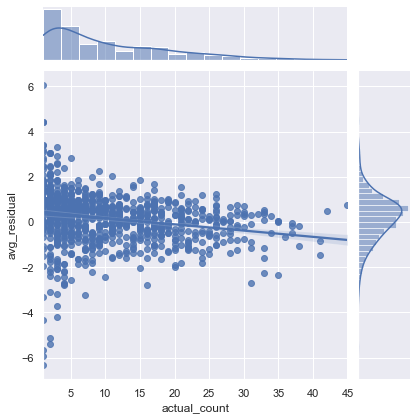

In [385]:
sns.jointplot(x = 'actual_count', y='avg_residual', data=grouped_predictions, kind='reg')

As the number of games increases ("actual count"), the avg_residuals cluster more tightly around 0 -- that's a good sign! While it may not be spot on at predicting points earned for individual games, it does fairly well over larger number of games

In [413]:
grouped_predictions['abs_avg_residual'] = abs(grouped_predictions['avg_residual'])

<AxesSubplot:xlabel='actual_count', ylabel='abs_avg_residual'>

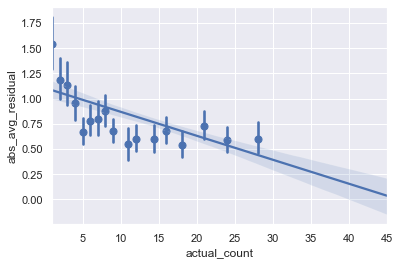

In [423]:
sns.regplot(x = 'actual_count', y = 'abs_avg_residual', data=grouped_predictions, x_bins = 20)

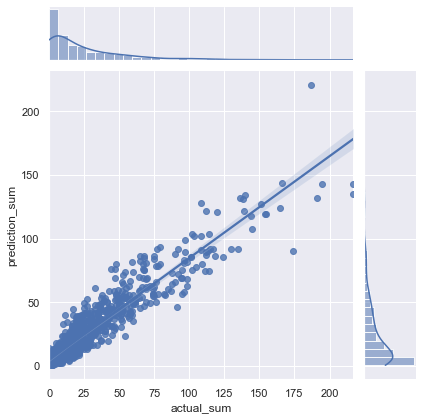

In [386]:
sns.jointplot(x = 'actual_sum', y='prediction_sum', data=grouped_predictions, kind='reg')

In [406]:
grouped_predictions.sort_values('actual_sum', ascending=False).head(15)

,name_,actual_sum,actual_count,prediction_sum,residuals_sum,avg_residual,bins
359,Harry Kane,217.0,33,142.726214,-74.273786,-2.250721,"(32.0, 36.0]"
419,Jamie Vardy,217.0,35,135.236911,-81.763089,-2.336088,"(32.0, 36.0]"
530,Kevin De Bruyne,195.0,33,142.764831,-52.235169,-1.582884,"(32.0, 36.0]"
493,Joshua King,191.0,41,131.750862,-59.249138,-1.445101,"(41.0, 45.0]"
772,Roberto Firmino,187.0,45,220.903316,33.903316,0.753407,"(41.0, 45.0]"
141,Callum Wilson,174.0,31,90.242924,-83.757076,-2.701841,"(27.0, 32.0]"
824,Sergio Agüero,166.0,28,143.253853,-22.746147,-0.812362,"(27.0, 32.0]"
226,David de Gea,165.0,38,124.312509,-40.687491,-1.070723,"(36.0, 41.0]"
366,Heung-Min Son,155.0,29,119.650064,-35.349936,-1.218963,"(27.0, 32.0]"
479,Jordan Pickford,154.0,41,119.190304,-34.809696,-0.849017,"(41.0, 45.0]"


In [407]:
grouped_predictions.sort_values('prediction_sum', ascending=False).head(15)

,name_,actual_sum,actual_count,prediction_sum,residuals_sum,avg_residual,bins
772,Roberto Firmino,187.0,45,220.903316,33.903316,0.753407,"(41.0, 45.0]"
824,Sergio Agüero,166.0,28,143.253853,-22.746147,-0.812362,"(27.0, 32.0]"
530,Kevin De Bruyne,195.0,33,142.764831,-52.235169,-1.582884,"(32.0, 36.0]"
359,Harry Kane,217.0,33,142.726214,-74.273786,-2.250721,"(32.0, 36.0]"
419,Jamie Vardy,217.0,35,135.236911,-81.763089,-2.336088,"(32.0, 36.0]"
799,Sadio Mané,140.0,28,134.090938,-5.909062,-0.211038,"(27.0, 32.0]"
225,David Silva,136.0,29,131.883979,-4.116021,-0.141932,"(27.0, 32.0]"
493,Joshua King,191.0,41,131.750862,-59.249138,-1.445101,"(41.0, 45.0]"
765,Riyad Mahrez,138.0,37,131.389102,-6.610898,-0.178673,"(36.0, 41.0]"
336,Georginio Wijnaldum,108.0,42,128.065936,20.065936,0.477760,"(41.0, 45.0]"


## How does this model compare to a technique of assuming players will earn the same number of points as their average over the 5 previous game?

In [436]:
#merge the full players dataset so we can reference historical performance for the games in the test set
test_df = test_df.merge(players, on=['name', 'date'])

In [437]:
test_df.head()

,actual,prediction,residuals,name,date,gw,position,minutes,team,opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,value,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp,spi_d,proj_score_d,total_points_shift,bps_shift,creativity_shift,ict_index_shift,influence_shift,threat_shift,minutes_shift,transfers_balance_shift,total_points_shift_3,bps_shift_3,creativity_shift_3,ict_index_shift_3,influence_shift_3,threat_shift_3,total_points_shift_5,bps_shift_5,creativity_shift_5,ict_index_shift_5,influence_shift_5,threat_shift_5,total_points_shift_7,bps_shift_7,creativity_shift_7,ict_index_shift_7,influence_shift_7,threat_shift_7,total_points_shift_30,bps_shift_30,creativity_shift_30,ict_index_shift_30,influence_shift_30,threat_shift_30,minutes_shift_2,transfers_balance_shift_2,minutes_shift_3,transfers_balance_shift_3,minutes_shift_5,transfers_balance_shift_5,total_mins_past_3,gk_points_3,def_points_3,mid_points_3,fwd_points_3,gk_points_5,def_points_5,mid_points_5,fwd_points_5,gk_points_7,def_points_7,mid_points_7,fwd_points_7,gk_points_12,def_points_12,mid_points_12,fwd_points_12,team_opp,gk_points_3_opp,def_points_3_opp,mid_points_3_opp,fwd_points_3_opp,gk_points_5_opp,def_points_5_opp,mid_points_5_opp,fwd_points_5_opp,gk_points_7_opp,def_points_7_opp,mid_points_7_opp,fwd_points_7_opp,gk_points_12_opp,def_points_12_opp,mid_points_12_opp,fwd_points_12_opp,gk_points_3_adv,gk_points_5_adv,gk_points_7_adv,gk_points_12_adv,def_points_3_adv,def_points_5_adv,def_points_7_adv,def_points_12_adv,mid_points_3_adv,mid_points_5_adv,mid_points_7_adv,mid_points_12_adv,fwd_points_3_adv,fwd_points_5_adv,fwd_points_7_adv,fwd_points_12_adv
0,7.0,3.087246,-3.912754,Bernd Leno,2018-12-08,16,1,90,Arsenal,Huddersfield Town,True,7,0,1,22,1,0.0,0,0,0.6,6.4,0,0,0,0,124446,0,1,0.0,14441,16815,2374,0,2018-12-08T15:00:00Z,1819,0.0,Huddersfield Town,82.64,61.31,2.31,0.48,0.7759,0.0599,0.1642,71.2,46.7,21.33,1.83,2.0,22.0,0.0,2.5,24.6,0.0,90.0,1130.0,2.333333,18.333333,1.255292e-13,2.666667,26.600000,0.000000,2.8,17.0,4.973799e-14,2.70,26.88,0.0,2.428571,15.714286,6.902415e-14,2.285714,22.828571,0.000000,1.466667,9.333333,1.667407e-13,1.386667,13.853333,0.000000,90.0,539.5,90.000000,541.000000,90.0,844.2,270.000000,3.666667,13.000000,16.333333,11.666667,3.6,12.6,15.6,9.4,3.142857,10.571429,15.714286,9.571429,3.416667,12.666667,17.500000,12.083333,Huddersfield Town,1.666667,11.666667,5.666667,1.333333,2.6,15.0,12.6,2.4,3.000000,16.142857,11.857143,2.428571,2.583333,13.833333,10.083333,2.416667,2.000000,1.0,0.142857,0.833333,1.333333,-2.4,-5.571429,-1.166667,10.666667,3.0,3.857143,7.416667,10.333333,7.0,7.142857,9.666667
1,1.0,2.695067,1.695067,John Lundstram,2020-07-20,37,2,21,Sheffield United,Everton,True,1,0,0,8,0,2.5,0,0,0.8,5.0,0,0,0,0,2228524,1,0,0.0,166,28290,28124,0,2020-07-20T17:00:00Z,1920,0.0,Everton,72.16,74.13,1.11,1.10,0.3536,0.3489,0.2975,0.0,0.0,-1.97,0.01,1.0,3.0,3.5,0.8,1.0,3.0,45.0,3090.0,0.666667,2.666667,1.366667e+00,0.533333,2.866667,1.000000,0.4,1.6,8.200000e-01,0.32,1.72,0.6,0.428571,3.857143,1.800000e+00,0.514286,2.771429,0.571429,3.466667,12.866667,9.086667e+00,3.203333,10.753333,12.066667,36.0,-30932.0,24.000000,-119740.333333,14.4,-179661.0,105.000000,4.000000,16.000000,6.000000,11.333333,4.4,20.8,7.0,8.6,3.428571,17.857143,7.571429,8.285714,4.000000,19.750000,7.166667,8.000000,Everton,3.333333,10.666667,17.666667,3.333333,3.0,9.8,14.8,3.2,3.142857,14.142857,15.714286,3.857143,3.250000,11.750000,14.750000,4.750000,0.666667,1.4,0.285714,0.750000,5.333333,11.0,3.714286,8.000000,-11.666667,-7.8,-8.142857,-7.583333,8.000000,5.4,4.428571,3.250000
2,1.0,1.266103,0.266103,Shane Long,2019-01-02,21,4,45,Southampton,Chelsea,False,1,0,0,3,0,1.8,0,0,0.6,3.4,0,0,0,0,6

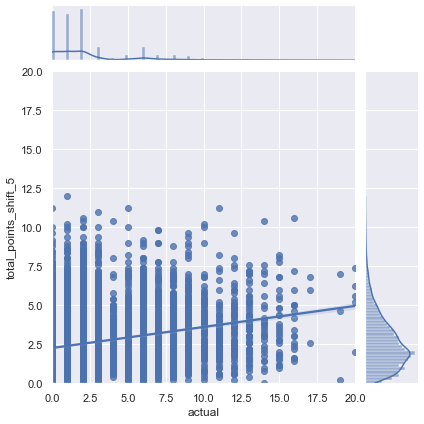

In [440]:
sns.jointplot(x = 'actual', y='total_points_shift_5', data=test_df, kind='reg', xlim = [0,20], ylim = [0,20])

In [445]:
grouped_predictions = grouped_predictions.merge(test_df.groupby('name')['total_points_shift_5'].sum().reset_index(), 
                          left_on='name_', right_on='name')

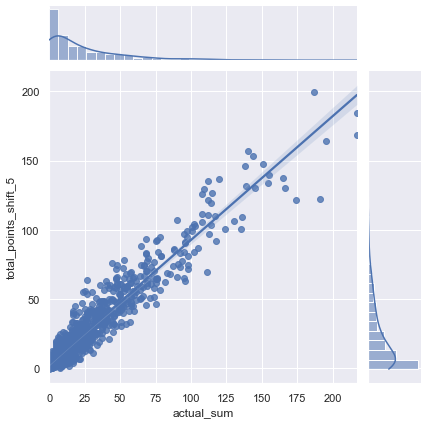

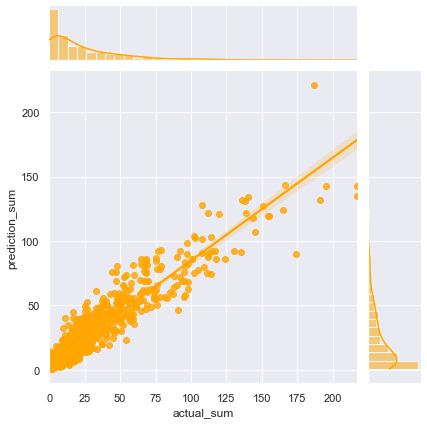

In [525]:
sns.jointplot(x = 'actual_sum', y='total_points_shift_5', data=grouped_predictions, kind='reg', color='b')
sns.jointplot(x = 'actual_sum', y='prediction_sum', data=grouped_predictions, kind='reg', color='orange')

In [461]:
grouped_predictions['shift_5_residual'] = grouped_predictions['total_points_shift_5'] - grouped_predictions['actual_sum']

In [465]:
grouped_predictions['abs_shift_5_residual'] = abs(grouped_predictions['shift_5_residual'])

In [468]:
grouped_predictions['abs_avg_shift_5_residual'] = grouped_predictions['abs_shift_5_residual']/grouped_predictions['actual_count']

<AxesSubplot:xlabel='actual_count', ylabel='abs_avg_residual'>

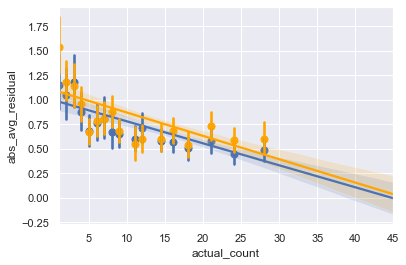

In [524]:
sns.regplot(x = 'actual_count', y = 'abs_avg_shift_5_residual', data=grouped_predictions, x_bins = 20, color='b')
sns.regplot(x = 'actual_count', y = 'abs_avg_residual', data=grouped_predictions, x_bins = 20, color='orange')

<AxesSubplot:xlabel='actual_count', ylabel='abs_avg_residual'>

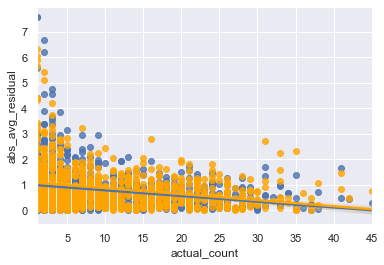

In [523]:
sns.regplot(data=grouped_predictions, x='actual_count', y='abs_avg_shift_5_residual', color ='b')
sns.regplot(data=grouped_predictions, x='actual_count', y='abs_avg_residual', color ='orange')

In [476]:
np.sqrt(np.square(grouped_predictions.shift_5_residual).mean())
#rmse on aggregated test data using average over last 5 games: ~9.45 

9.456579993871832

In [481]:
np.sqrt(mean_squared_error(test_df['actual'], test_df['total_points_shift_5']))

3.1211587462869197

In [480]:
np.sqrt(mean_squared_error(test_df['actual'], test_df['prediction']))

2.814885001957561

In [475]:
np.sqrt(np.square(grouped_predictions.residuals_sum).mean())
#rmse on aggregated test data using DTR: ~11.19

11.199740062983194

In [489]:
test_df['abs_residuals'] = abs(test_df['residuals'])

In [501]:
test_df['shift_5_abs_residual'] = abs(test_df['total_points_shift_5'] - test_df['actual'])

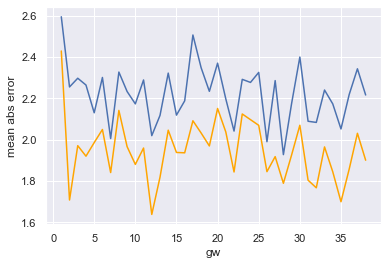

In [536]:
data = test_df.groupby('gw').agg({'shift_5_abs_residual': 'mean', 'abs_residuals': 'mean'}).reset_index()
sns.lineplot(data=data, x='gw', y='shift_5_abs_residual', color='b')
sns.lineplot(data=data, x='gw', y='abs_residuals', color='orange')
plt.ylabel('mean abs error');

The sad truth is that while the DTR model reasonably more effective at at predicting a player's performance each game (in this example, there was an RMSE of 2.8 for DTR, vs. 3.1 for the simple prediction model), it isn't better once games are aggregated. So if we were to have an entirely different team every week, the DTR model would be better, but keeping in mind that we will hold players for multiple weeks, it offers little advantage over the simple prediction model.

Something to keep in mind here, and that my current workflow doesn't test, is that what I really want to predict is how a player will do ovre 5 consecutive gameweeks. Agregating this way could lead to different results. 

# XG Boost

In [558]:
import xgboost as xgb

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/xgboost/data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/xgboost/data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/xgboost/data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/xgboost/data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/andrewpeters/anaconda3/lib/python3.8/site-pac

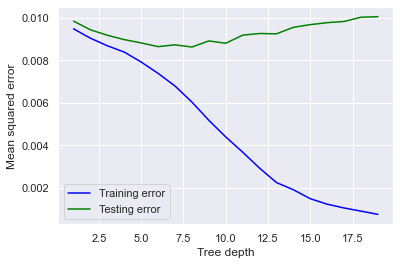

In [567]:
training_error = []
testing_error = []

max_depths = range(1, 20)

for depth in max_depths:
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 10, seed = 123, max_depth=depth)
    model.fit(X_train, y_train)
    training_error.append(mean_squared_error(model.predict(X_train), y_train))
    testing_error.append(mean_squared_error(model.predict(X_test), y_test))

plt.plot(max_depths, training_error, color='blue', label='Training error')
plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('Tree depth')
plt.ylabel('Mean squared error')
plt.legend()

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/xgboost/data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/xgboost/data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/xgboost/data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/xgboost/data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/andrewpeters/anaconda3/lib/python3.8/site-pac

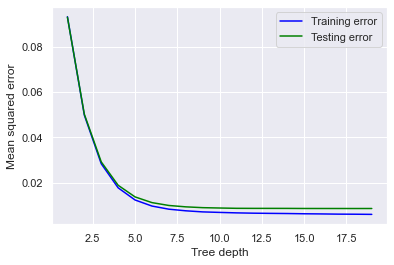

In [568]:
training_error = []
testing_error = []

estimators = range(1, 20)

for est in estimators:
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = est, seed = 123, max_depth=7)
    model.fit(X_train, y_train)
    training_error.append(mean_squared_error(model.predict(X_train), y_train))
    testing_error.append(mean_squared_error(model.predict(X_test), y_test))

plt.plot(max_depths, training_error, color='blue', label='Training error')
plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('N_estimators')
plt.ylabel('Mean squared error')
plt.legend()

In [573]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 10, seed = 123, max_depth = 6)

In [574]:
xgb_reg.fit(X_train,y_train)

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/xgboost/data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [575]:
y_pred = xgb_reg.predict(X_test)

In [576]:
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
scaler.inverse_transform(rmse_xgb.reshape(-1,1))

#with zero parameter tuning, XGB returns a rmse of ~2.69, about a 5% improvement over the Decision Tree 

array([[2.69739344]])

# The code below this is somewhat out of date and needs to be revamped.

Much of what follows is probably unneccesary and could be made more clear/efficient. 

# Make Predictions for Unplayed Games

In [195]:
last_gw = players.groupby(['season', 'gw'])['total_points'].count().reset_index()['gw'].tail(1).values

In [196]:
last_gw = int(last_gw)

In [203]:
last_results = players[(players.gw == last_gw) & (players.season == 2021)]

In [204]:
#The teachnique will be to merge the last_results with the next 5 games for each player

In [205]:
# add today's date -- only want to look at games in the SPI df after this date
today = '2020-11-3'

In [206]:
spi_2020 = spi[(spi['date'] > today) & (spi['date'] < '2021-06-01')]

In [207]:
drop_cols = ['date',
            'team_opp',
            'spi',
            'spi_opp',
            'proj_score',
            'proj_score_opp',
            'prob_w',
            'prob_l',
            'probtie',
            'importance',
            'importance_opp',
            'opponent_team',
            'was_home',
            'kickoff_time',
            'gw',
            'value']

In [208]:
last_results = last_results.drop(columns=drop_cols)

In [209]:
future = pd.DataFrame()
for player in last_results.name.unique():
    section = last_results[last_results['name'] == player]
    section = section.merge(spi_2020)
    section['gw'] = np.arange(len(section)) + last_gw
    future = future.append(section)

In [210]:
future = future[future['gw'] <= last_gw + 5]

In [211]:
future.isnull().sum()

name                            0
position                        0
minutes                         0
team                            0
total_points                    0
assists                         0
bonus                           0
bps                             0
clean_sheets                    0
creativity                      0
goals_conceded                  0
goals_scored                    0
ict_index                       0
influence                       0
penalties_missed                0
penalties_saved                 0
red_cards                       0
saves                           0
selected                        0
team_a_score                    0
team_h_score                    0
threat                          0
transfers_balance               0
transfers_in                    0
transfers_out                   0
yellow_cards                    0
season                          0
spi_d                           0
proj_score_d                    0
total_points_s

In [335]:
player = 'Matt Doherty'

In [375]:
section['team'] = section.team.astype('str')

In [376]:
section = last_results[last_results['name'] == player]
section = section.merge(spi_2020, left_on='team', right_on='team')

In [366]:
spi_2020['team'] = spi_2020.team.astype('str')

In [367]:
spi_2020[spi_2020['date'] == '2020-10-26']['team']

35850    Brighton and Hove Albion
35859                     Burnley
35850        West Bromwich Albion
35859           Tottenham Hotspur
Name: team, dtype: object

In [377]:
section.date.unique()

array(['2020-11-01', '2020-11-21', '2020-12-05', '2020-12-19',
       '2020-12-28', '2021-01-02', '2021-01-27', '2021-02-03',
       '2021-02-06', '2021-02-27', '2021-03-06', '2021-03-20',
       '2021-04-10', '2021-05-01', '2021-05-12', '2021-05-15',
       '2020-10-26', '2020-11-07', '2020-11-29', '2020-12-12',
       '2020-12-16', '2020-12-26', '2021-01-12', '2021-01-16',
       '2021-01-30', '2021-02-13', '2021-02-20', '2021-03-13',
       '2021-04-03', '2021-04-17', '2021-04-24', '2021-05-08',
       '2021-05-23'], dtype=object)

In [380]:
#not everyone's affected -- Arsenal's dates look right
players[players.team == 'Arsenal'].sort_values('date').date.unique()

array(['2016-08-20', '2016-08-27', '2016-09-10', '2016-09-17',
       '2016-09-24', '2016-10-02', '2016-10-15', '2016-10-22',
       '2016-10-29', '2016-11-06', '2016-11-19', '2016-11-27',
       '2016-12-03', '2016-12-10', '2016-12-13', '2016-12-18',
       '2016-12-26', '2017-01-01', '2017-01-03', '2017-01-14',
       '2017-01-22', '2017-01-31', '2017-02-04', '2017-02-11',
       '2017-03-04', '2017-03-18', '2017-04-02', '2017-04-05',
       '2017-04-10', '2017-04-17', '2017-04-26', '2017-04-30',
       '2017-05-07', '2017-05-10', '2017-05-13', '2017-05-16',
       '2017-05-21', '2017-08-11', '2017-08-19', '2017-08-27',
       '2017-09-09', '2017-09-17', '2017-09-25', '2017-10-01',
       '2017-10-14', '2017-10-22', '2017-10-28', '2017-11-05',
       '2017-11-18', '2017-11-26', '2017-11-29', '2017-12-02',
       '2017-12-10', '2017-12-13', '2017-12-16', '2017-12-22',
       '2017-12-28', '2017-12-31', '2018-01-03', '2018-01-14',
       '2018-01-20', '2018-01-30', '2018-02-03', '2018-

In [381]:
future[future.team == 'Arsenal'].sort_values('date').date.unique()

array(['2020-10-25', '2020-11-07', '2020-11-28', '2020-12-13',
       '2020-12-15', '2020-12-26'], dtype=object)

In [218]:
for team in future.team.unique():
    importance_fill = importance_by_team[importance_by_team.team == team]['importance'].values[0]
    importance_opp_fill = importance_by_team[importance_by_team.team == team]['importance_opp'].values[0]
    future.loc[(future.importance.isnull()) & (future.team == team), 'importance'] = importance_fill
    future.loc[(future.importance_opp.isnull()) & (future.team == team), 'importance_opp'] = importance_opp_fill

# predict future scores

In [222]:
X_future, _, scaler, _, _ = process(future)

In [223]:
predictions = scaler.inverse_transform(clf.predict(X_future).reshape(-1,1))

In [224]:
future['clf_pred'] = predictions

In [225]:
# just out of curiousity: what's the range of predicitions for each players?
future.groupby(['name']).apply(lambda x: f'{x.clf_pred.max() - x.clf_pred.min():.2f}')

name
Aaron Connolly                             6.45
Aaron Cresswell                            9.38
Aaron Ramsdale                             3.52
Abdoulaye Doucouré                         2.34
Aboubakar Kamara                           1.76
Adam Webster                               2.93
Adama Traoré                               0.00
Aleksandar Mitrović                        6.45
Alex McCarthy                              2.93
Alexandre Lacazette                        7.03
Alisson Ramses Becker                      5.86
Allan Marques Loureiro                     2.93
Allan Saint-Maximin                        4.69
Andreas Christensen                        3.52
Andrew Robertson                           4.69
Andros Townsend                            5.86
André Filipe Tavares Gomes                 7.62
André-Frank Zambo Anguissa                 9.97
Andy Carroll                               4.10
Angelo Ogbonna                             2.93
Anthony Martial                    

# add in any injuries & make sure prices are most current

In [219]:
injuries = pd.read_csv('data/2020-21/soccer-injury-report.csv')

In [220]:
list(injuries)

['Player', 'Team', 'Pos', 'Injury', 'Status', 'Est. Return']

In [227]:
#list of names that the model should not pick -- these might be known injuries, for example
#these get removed from the selection dataframe when running the optimizer

do_not_pick = list(injuries.Player)

In [228]:
do_not_pick.extend(['Tammy Abraham', 'Tariq Lamptey', 'Martin Dubravka', 
               'Kevin De Bruyne', 'Jamaal Lascelles', 'Raheem Sterling', 'Nicolás Otamendi',
              'Eric Garcia', 'Adrián Bernabé', 'João Pedro Cavaco Cancelo', 'Claudio Bravo', 
                    'Riyad Mahrez', 'Tommy Doyle', 'Cole Palmer', 'Ilkay Gündogan'])

# Use FPL API to bring in most recent values

In [232]:
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
r = requests.get(url)
json = r.json()
json.keys()
elements = pd.DataFrame(json['elements'])

In [247]:
list(elements)

['chance_of_playing_next_round',
 'chance_of_playing_this_round',
 'code',
 'cost_change_event',
 'cost_change_event_fall',
 'cost_change_start',
 'cost_change_start_fall',
 'dreamteam_count',
 'element_type',
 'ep_next',
 'ep_this',
 'event_points',
 'first_name',
 'form',
 'id',
 'in_dreamteam',
 'news',
 'news_added',
 'now_cost',
 'photo',
 'points_per_game',
 'second_name',
 'selected_by_percent',
 'special',
 'squad_number',
 'status',
 'team',
 'team_code',
 'total_points',
 'transfers_in',
 'transfers_in_event',
 'transfers_out',
 'transfers_out_event',
 'value_form',
 'value_season',
 'web_name',
 'minutes',
 'goals_scored',
 'assists',
 'clean_sheets',
 'goals_conceded',
 'own_goals',
 'penalties_saved',
 'penalties_missed',
 'yellow_cards',
 'red_cards',
 'saves',
 'bonus',
 'bps',
 'influence',
 'creativity',
 'threat',
 'ict_index',
 'influence_rank',
 'influence_rank_type',
 'creativity_rank',
 'creativity_rank_type',
 'threat_rank',
 'threat_rank_type',
 'ict_index_rank'

In [278]:
costs = elements[['first_name', 'second_name', 'now_cost', 'id']]

In [279]:
costs['name'] = costs.first_name.str.cat(costs.second_name, sep = ' ')

In [280]:
costs['value'] = costs['now_cost']

In [281]:
future = future.merge(costs[['name', 'value']] , on='name')

# Solve Knapsack problem

In [254]:
import pulp

In [255]:
def select_team(expected_scores, prices, positions, clubs, total_budget=99.6, sub_factor=0.2):
    num_players = len(expected_scores)
    model = pulp.LpProblem("Constrained value maximisation", pulp.LpMaximize)
    decisions = [
        pulp.LpVariable("x{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]
    captain_decisions = [
        pulp.LpVariable("y{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]
    sub_decisions = [
        pulp.LpVariable("z{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]


    # objective function:
    model += sum((captain_decisions[i] + decisions[i] + sub_decisions[i]*sub_factor) * expected_scores[i]
                 for i in range(num_players)), "Objective"

    # cost constraint
    model += sum((decisions[i] + sub_decisions[i]) * prices[i] for i in range(num_players)) <= total_budget  # total cost

    # position constraints
    # 1 starting goalkeeper
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 1) == 1
    # 2 total goalkeepers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 1) == 2

    # 3-5 starting defenders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) <= 5
    # 5 total defenders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 2) == 5

    # 3-5 starting midfielders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) <= 5
    # 5 total midfielders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 3) == 5

    # 1-3 starting attackers
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) >= 1
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) <= 3
    # 3 total attackers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 4) == 3

    # club constraint
    for club_id in np.unique(clubs):
        model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if clubs[i] == club_id) <= 3  # max 3 players

    model += sum(decisions) == 11  # total team size
    model += sum(captain_decisions) == 1  # 1 captain
    
    for i in range(num_players):  
        model += (decisions[i] - captain_decisions[i]) >= 0  # captain must also be on team
        model += (decisions[i] + sub_decisions[i]) <= 1  # subs must not be on team

    model.solve()
    print("Total expected score = {}".format(model.objective.value()))

    return decisions, captain_decisions, sub_decisions

In [256]:
data = future[(future['gw'] > last_gw) & (future['gw'] <= last_gw + 5 )]
data = data.groupby(['name', 'position', 'team', 'value'])['clf_pred'].sum().reset_index()
data = data.drop(index=list(data[data.name.isin(do_not_pick)].index))
expected_scores = data.clf_pred.values
prices = data.value.values / 10
positions = data.position.values
clubs = data.team.values
names = data.name.values
decisions, captain_decisions, sub_decisions = select_team(expected_scores, prices, positions, clubs)

Total expected score = 523.951724137931


In [257]:
chosen_names = []
chosen_points = []
chosen_position = []
actual_points = []
chosen_price = []
player_indices = []
for i in range(len(data)):
    if decisions[i].value() !=0:
        chosen_names.append(names[i])
        chosen_points.append(expected_scores[i])
        chosen_position.append(positions[i])
        chosen_price.append(prices[i])
        player_indices.append(i)
chosen_ones = pd.DataFrame(zip(chosen_names, chosen_points, chosen_position, chosen_price), columns=['name', 'pred', 'pos', 'price'])

sub_names = []
sub_points = []
sub_position = []
actual_points = []
sub_price = []
for i in range(len(data)):
    if sub_decisions[i].value() !=0:
        sub_names.append(names[i])
        sub_points.append(expected_scores[i])
        sub_position.append(positions[i])
        sub_price.append(prices[i])
subs = pd.DataFrame(zip(sub_names, sub_points, sub_position, sub_price), columns= ['name', 'pred', 'pos', 'price'])

In [258]:
chosen_ones.sort_values('pos')

,name,pred,pos,price
7,Nick Pope,29.310345,1,5.5
2,Ezri Konsa Ngoyo,49.827586,2,4.7
3,Gabriel Magalhães,39.862069,2,5.1
6,Matt Doherty,43.379310,2,5.8
10,Çaglar Söyüncü,42.206897,2,5.4
0,Ashley Westwood,40.448276,3,5.4
1,Conor Hourihane,41.034483,3,6.0
4,Jack Harrison,43.965517,3,5.5
5,Jordan Henderson,38.689655,3,5.4
9,Rodrigo Hernandez,38.103448,3,5.4


In [259]:
subs.sort_values('pos')

,name,pred,pos,price
2,Hugo Lloris,25.793103,1,5.5
0,Fernando Luiz Rosa,38.103448,2,5.5
1,Harry Kane,29.896552,4,10.8
3,Michail Antonio,28.724138,4,6.3


In [315]:
chosen_ones.merge(players[players.name.isin(chosen_ones.name)].groupby('name')['total_points_shift_5'].mean().reset_index(), on='name')

,name,pred,pos,price,total_points_shift_5
0,Ashley Westwood,40.448276,3,5.4,2.919048
1,Conor Hourihane,41.034483,3,6.0,2.741176
2,Ezri Konsa Ngoyo,49.827586,2,4.7,2.791667
3,Gabriel Magalhães,39.862069,2,5.1,11.750000
4,Jack Harrison,43.965517,3,5.5,5.611111
5,Jordan Henderson,38.689655,3,5.4,2.787993
6,Matt Doherty,43.379310,2,5.8,4.069406
7,Nick Pope,29.310345,1,5.5,4.275676
8,Roberto Firmino,42.793103,4,9.3,4.579710
9,Rodrigo Hernandez,38.103448,3,5.4,2.610294


In [314]:
subs.merge(players[players.name.isin(sub_names)].groupby('name')['total_points_shift_5'].mean().reset_index(), on='name')

,name,pred,pos,price,total_points_shift_5
0,Fernando Luiz Rosa,38.103448,2,5.5,2.582589
1,Harry Kane,29.896552,4,10.8,5.713750
2,Hugo Lloris,25.793103,1,5.5,3.991453
3,Michail Antonio,28.724138,4,6.3,4.025000


In [262]:
# Sanity Check -- how have these players in their past 5 games?
players[players.name.isin(chosen_names)].groupby('name').tail(5)[['name', 'gw', 'opponent_team', 'total_points', 'clf_pred']]

,name,gw,opponent_team,total_points,clf_pred
9293,Ashley Westwood,38,Brighton and Hove Albion,3.0,3.0
9294,Ashley Westwood,2,Leicester City,2.0,2.0
9295,Ashley Westwood,3,Southampton,2.0,2.0
9296,Ashley Westwood,4,Newcastle United,8.0,8.0
9297,Ashley Westwood,5,West Bromwich Albion,2.0,2.0
18778,Conor Hourihane,37,Arsenal,3.0,3.0
18779,Conor Hourihane,38,West Ham United,3.0,3.0
18780,Conor Hourihane,2,Sheffield United,3.0,3.0
18781,Conor Hourihane,3,Fulham,14.0,14.0
18782,Conor Hourihane,4,Liverpool,0.0,0.0


In [497]:
# Expectations
future[future.name.isin(chosen_names)].groupby('name').tail(5)[['name', 'gw', 'team_opp', 'total_points_shift_30', 'clf_pred']]

,name,gw,team_opp,total_points_shift_30,clf_pred
1,Conor Hourihane,4,Southampton,2.266667,14.0
2,Conor Hourihane,5,Brighton and Hove Albion,2.266667,14.0
3,Conor Hourihane,6,Newcastle United,2.266667,14.0
4,Conor Hourihane,7,Burnley,2.266667,14.0
5,Conor Hourihane,8,Crystal Palace,2.266667,14.0
1,Ezri Konsa Ngoyo,4,Southampton,2.633333,6.0
2,Ezri Konsa Ngoyo,5,Brighton and Hove Albion,2.633333,6.0
3,Ezri Konsa Ngoyo,6,Newcastle United,2.633333,6.0
4,Ezri Konsa Ngoyo,7,Burnley,2.633333,6.0
5,Ezri Konsa Ngoyo,8,Crystal Palace,2.633333,6.0


# Implement Subbing System

Thanks to: https://github.com/joconnor-ml/forecasting-fantasy-football/blob/master/notebooks/Linearly%20Optimising%20FPL%20Teams%20(Part%202).ipynb

In [426]:
model = pulp.LpProblem("Transfer optimisation", pulp.LpMaximize)

data = future[(future['gw'] > last_gw + 1) & (future['gw'] <= last_gw + 6 )]
data = data.groupby(['name', 'position', 'team', 'value'])['clf_pred'].sum().reset_index()
data = data.drop(index=list(data[data.name.isin(do_not_pick)].index))

expected_scores = data.clf_pred.values
num_players = len(data)
prices = data.value.values / 10
positions = data.position.values
clubs = data.team.values
names = data.name.values

current_team_indices = player_indices

current_team_decisions = np.zeros(num_players) 
current_team_decisions[current_team_indices] = 1

transfer_in_decisions = [
    pulp.LpVariable("x{}".format(i), lowBound=0, upBound=1, cat='Integer')
    for i in range(num_players)
]
transfer_out_decisions = [
    pulp.LpVariable("y{}".format(i), lowBound=0, upBound=1, cat='Integer')
    for i in range(num_players)
]

next_week_team = [
    current_team_decisions[i] + transfer_in_decisions[i] - transfer_out_decisions[i]
    for i in range(num_players)
]

In [427]:
for i in range(num_players):
    model += next_week_team[i] <= 1
    model += next_week_team[i] >= 0
    model += (transfer_in_decisions[i] + transfer_out_decisions[i]) <= 1
    
# formation constraints
# 1 starting goalkeeper
model += sum(next_week_team[i] for i in range(num_players) if positions[i] == 1) == 1

# 3-5 starting defenders
model += sum(next_week_team[i] for i in range(num_players) if positions[i] == 2) >= 3
model += sum(next_week_team[i] for i in range(num_players) if positions[i] == 2) <= 5

# 3-5 starting midfielders
model += sum(next_week_team[i] for i in range(num_players) if positions[i] == 3) >= 3
model += sum(next_week_team[i] for i in range(num_players) if positions[i] == 3) <= 5

# 1-3 starting attackers
model += sum(next_week_team[i] for i in range(num_players) if positions[i] == 4) >= 1
model += sum(next_week_team[i] for i in range(num_players) if positions[i] == 4) <= 3

# club constraint
for club_id in np.unique(clubs):
    model += sum(next_week_team[i] for i in range(num_players) if clubs[i] == club_id) <= 3  # max 3 players

model += sum(next_week_team) == 11  # total team size

In [428]:
# placeholder budget and prices
budget_now = 0
buy_prices = sell_prices = data.value.values / 10

transfer_in_cost = sum(transfer_in_decisions[i] * buy_prices[i] for i in range(num_players))
transfer_out_cost = sum(transfer_in_decisions[i] * sell_prices[i] for i in range(num_players))

budget_next_week = budget_now + transfer_out_cost - transfer_in_cost
model += budget_next_week >= 0

In [448]:
# objective function:
model += sum((next_week_team[i]) * expected_scores[i]
             for i in range(num_players)), "Objective"

In [449]:
model.solve()

1

In [450]:
for i in range(num_players):
    if transfer_in_decisions[i].value() == 1:
        print("Transferred in: {} {} {}".format(names[i], buy_prices[i], expected_scores[i]))
    if transfer_out_decisions[i].value() == 1:
        print("Transferred out: {} {} {}".format(names[i], sell_prices[i], expected_scores[i]))

Transferred in: Adam Webster 4.5 72.0
Transferred in: Adama Traoré 6.4 54.0
Transferred out: Gabriel Magalhães 5.1 48.0
Transferred out: Lewis Dunk 4.9 49.0


# Next Up
- figure out why certain values aren't merging
- Use the API to bring in current teams
- Use the API to bring in up to date data (if needed)
- Clean up optimizer models and implement as functinos
- Looks like SPI data is missing the spurs v. burnely game on 10-26


In [66]:
'''
If end up neede to use the api to get recent player info: here it is! # in url represents player id
url = 'https://fantasy.premierleague.com/api/element-summary/4/'
r = requests.get(url)
json = r.json()
json.keys()
pd.DataFrame(json['history'])
'''

In [87]:
gw = 6
my_team = 'http://fantasy.premierleague.com/api/entry/5171826/event/' + str(gw) + '/picks/'

In [88]:
my_team = requests.get(my_team)

In [89]:
my_team = my_team.json()

In [90]:
my_team.keys()

dict_keys(['active_chip', 'automatic_subs', 'entry_history', 'picks'])

In [275]:
current_team = []
for player_num in range(15):
    current_team.append(my_team['picks'][player_num]['element'])

In [273]:
current_team

[12, 97, 155, 519, 284, 37, 251, 254, 202, 460, 117, 363, 518, 16, 319]

In [288]:
#Use the costs table to look up player names by id
current_team = costs[costs.id.isin(current_team)]['name']

In [289]:
current_team

14           Rob Holding
33     Emiliano Martínez
43         Jack Grealish
112       Charlie Taylor
116          Jimmy Dunne
135          Timo Werner
184          Lucas Digne
265       Nampalys Mendy
278      Patrick Bamford
308           Sadio Mané
311        Mohamed Salah
344           Phil Foden
384          Teden Mengi
449        Alex McCarthy
565         Raúl Jiménez
Name: name, dtype: object

In [294]:
points = future[future.name.isin(current_team)]['clf_pred'].sum()
print('The model predicts this team will earn {:.2f} points over the next 5 gameweeks'.format(points))

The model predicts this team will earn 286.66 points over the next 5 gameweeks


In [307]:
this_gw = future[(future.gw == last_gw + 1) & (future.name.isin(current_team))]['clf_pred'].sum()
print('The model predicts this team will earn {:.2f} points this gameweek'.format(this_gw))

The model predicts this team will earn 45.14 points this gameweek


In [311]:
future[(future.gw == last_gw) & (future.name.isin(current_team))]

,level_1,name,position,minutes,team,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,season,xP,element,fixture,own_goals,round,spi_d,proj_score_d,total_points_shift,bps_shift,creativity_shift,ict_index_shift,influence_shift,threat_shift,minutes_shift,transfers_balance_shift,name_3_x,level_1_x,total_points_shift_3,bps_shift_3,creativity_shift_3,ict_index_shift_3,influence_shift_3,threat_shift_3,name_5_x,total_points_shift_5,bps_shift_5,creativity_shift_5,ict_index_shift_5,influence_shift_5,threat_shift_5,name_7,total_points_shift_7,bps_shift_7,creativity_shift_7,ict_index_shift_7,influence_shift_7,threat_shift_7,name_30,total_points_shift_30,bps_shift_30,creativity_shift_30,ict_index_shift_30,influence_shift_30,threat_shift_30,name_1,level_1_y,minutes_shift_1,transfers_balance_shift_1,name_2,minutes_shift_2,transfers_balance_shift_2,name_3_y,minutes_shift_3,transfers_balance_shift_3,name_5_y,minutes_shift_5,transfers_balance_shift_5,clf_pred,mse,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp,gw,value_x,value_y
48,3982,Alex McCarthy,1,90,Southampton,6.0,0,0,26,1,0.0,0,0,1.5,14.6,0,0,0,2,1275332,1,0,0.0,-161277,55961,217238,0,2021,0.0,0.0,0.0,0.0,0.0,1.72,-0.16,0.0,9.0,0.0,1.3,12.8,0.0,90.0,-49369.0,Alex McCarthy,91423,1.333333,13.666667,0.000000,1.933333,19.000000,0.000000,Alex McCarthy,2.6,16.0,0.00,1.96,19.52,0.0,Alex McCarthy,2.428571,15.142857,0.000000,1.985714,19.828571,0.000000,Alex McCarthy,3.533333,17.233333,0.333333,2.320000,22.913333,0.000000,Alex McCarthy,3982,90.0,-49369.0,Alex McCarthy,90.0,-24684.5,Alex McCarthy,90.000000,-15111.666667,Alex McCarthy,90.0,-5534.8,4.689655,0.0,2020-10-25,Everton,72.99,76.77,1.38,1.46,0.3545,0.3887,0.2568,19.900000,50.200000,3,45,45
288,27681,Emiliano Martínez,1,90,Aston Villa,6.0,0,0,26,1,0.0,0,0,1.9,19.0,0,0,0,2,783041,3,0,0.0,333894,385360,51466,0,2021,0.0,0.0,0.0,0.0,0.0,5.81,-0.05,13.0,38.0,0.0,3.2,32.2,0.0,90.0,38079.0,Emiliano Martínez,91553,5.333333,20.666667,0.000000,2.600000,26.066667,0.000000,Emiliano Martínez,4.6,22.2,0.00,3.64,36.40,0.0,Emiliano Martínez,4.571429,21.571429,0.000000,3.228571,32.200000,0.000000,Emiliano Martínez,1.533333,6.900000,0.000000,0.966667,9.633333,0.000000,Emiliano Martínez,27681,90.0,38079.0,Emiliano Martínez,90.0,37731.0,Emiliano Martínez,90.000000,34892.000000,Emiliano Martínez,90.0,26019.6,0.586207,0.0,2020-10-23,Leeds,73.95,66.41,1.76,1.08,0.5280,0.2304,0.2416,40.800000,26.200000,3,48,48
456,38145,Jack Grealish,3,90,Aston Villa,8.0,0,0,29,1,25.0,0,1,13.1,45.4,0,0,0,0,658262,3,0,61.0,-48718,44657,93375,0,2021,0.0,0.0,0.0,0.0,0.0,5.81,-0.05,3.0,10.0,40.6,9.7,7.0,49.0,90.0,491.0,Jack Grealish,91619,5.666667,18.333333,29.800000,9.000000,21.333333,38.666667,Jack Grealish,4.4,16.6,31.80,8.68,17.40,37.4,Jack Grealish,3.714286,13.285714,27.114286,7.285714,14.142857,31.428571,Jack Grealish,3.666667,14.033333,30.886667,7.156667,18.113333,22.666667,Jack Grealish,38145,90.0,491.0,Jack Grealish,90.0,4680.0,Jack Grealish,90.000000,-4076.666667,Jack Grealish,90.0,-26124.6,1.758621,0.0,2020-10-23,Leeds,73.95,66.41,1.76,1.08,0.5280,0.2304,0.2416,40.800000,26.200000,3,72,72
744,55860,Lucas Digne,2,90,Everton,6.0,1,1,22,0,17.3,1,0,5.6,26.8,0,0,0,0,965634,2,1,12.0,43922,160549,116627,0,2021,0.0,0.0,0.0,0.0,0.0,6.09,0.13,1.0,19.0,75.5,10.9,21.8,12.0,90.0,275313.0,Lucas Digne,91734,4.666667,25.666667,44.566667,7.833333,29.000000,4.666667,Lucas Digne,4.2,21.6,31.64,6.28,23.92,7.2,Lucas Digne,3.857143,20.285714,33.642857,6.900000,26.571429,8.714286,Lucas Digne,3.366667,17.333333,28.863333,5.550000,20.533333,6.066667,Lucas Digne,55860,90.0,275313.0,Lucas Digne,90.0,137656.5,Lucas Digne,83.333333,102298.666667,Lucas Digne,86.0,74060.4,9.965517,0.0,2020-11-07,Manchester United,76.77,83.15,1.44,1.59,0.3441,0.4083,0.2476